# Librería Ruptures - Detección de Puntos de Cambio

La librería `ruptures` es una herramienta poderosa para detectar cambios estructurales en series temporales. En finanzas es útil para:

- **Detectar cambios de régimen** en volatilidad o correlaciones
- **Identificar crisis financieras** o eventos importantes
- **Segmentar períodos** para análisis separados
- **Detectar cambios en tendencias** de precios

## Conceptos clave:
- **Change point**: Momento en el tiempo donde cambian las propiedades estadísticas de la serie
- **Cost function**: Función que mide la "homogeneidad" de un segmento
- **Penalty**: Parámetro que controla cuántos puntos de cambio detectar

## Principales algoritmos:
- `Pelt`: Rápido y eficiente para series largas
- `Dynp`: Programación dinámica, más preciso pero lento
- `BottomUp`: Método jerárquico
- `Window`: Ventana deslizante

## Librerías

In [15]:

import pandas as pd
import numpy as np
import random

import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf


import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed



Puntos de cambio detectados en AAPL:
1. 2023-03-22


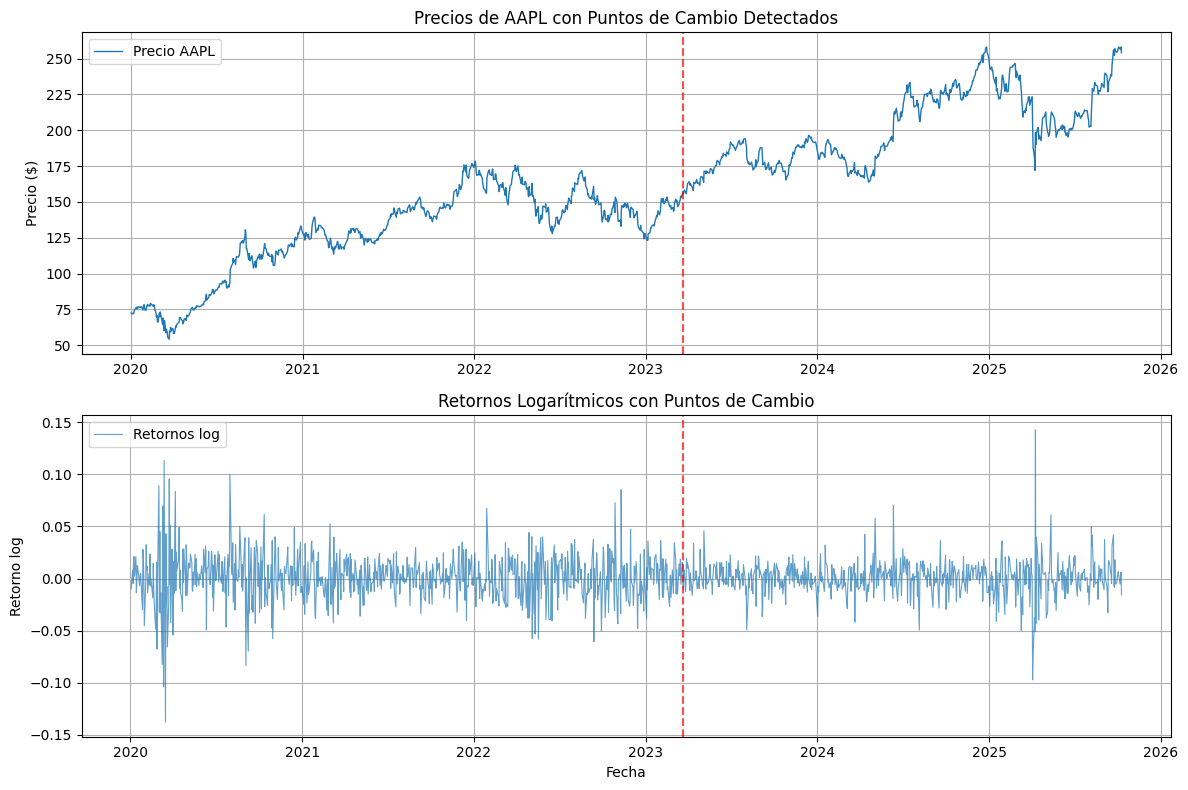

In [16]:

# =====================================
# EJEMPLO 1: Detectar cambios en precios de una acción
# =====================================

# Descargar datos de AAPL desde 2020
aapl_data = yf.download("AAPL", start="2020-01-01", auto_adjust=True)['Close']

# Convertir a retornos logarítmicos (más estables para análisis)
returns = np.log(aapl_data / aapl_data.shift(1)).dropna()

# Configurar el detector de puntos de cambio
# - model="rbf": Detecta cambios en la media y varianza
# - min_size=30: Mínimo 30 días entre cambios
min_size=30
algo = rpt.Pelt(model="rbf", min_size=min_size).fit(returns.values)

# Detectar puntos de cambio (penalty controla sensibilidad)
# Penalty más alto = menos puntos de cambio
penalty = 10  # Experimenta con valores entre 5-20, 10
change_points = algo.predict(pen=penalty)

# Los índices se refieren a posiciones en el array, convertir a fechas
change_dates = [returns.index[cp-1] for cp in change_points[:-1]]  # -1 porque el último es el final

print(f"Puntos de cambio detectados en AAPL:")
for i, date in enumerate(change_dates):
    print(f"{i+1}. {date.strftime('%Y-%m-%d')}")

# Graficar resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico 1: Precios con puntos de cambio
ax1.plot(aapl_data.index, aapl_data, label='Precio AAPL', linewidth=1)
for date in change_dates:
    ax1.axvline(x=date, color='red', linestyle='--', alpha=0.7)
ax1.set_title('Precios de AAPL con Puntos de Cambio Detectados')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Retornos con puntos de cambio
ax2.plot(returns.index, returns, label='Retornos log', linewidth=0.8, alpha=0.7)
for date in change_dates:
    ax2.axvline(x=date, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Retornos Logarítmicos con Puntos de Cambio')
ax2.set_ylabel('Retorno log')
ax2.set_xlabel('Fecha')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Cambios en volatilidad detectados:
1. 2020-02-28 - Vol antes: 0.0199, después: 0.0499
2. 2020-05-04 - Vol antes: 0.0409, después: 0.0175
3. 2020-07-29 - Vol antes: 0.0175, después: 0.0276
4. 2020-09-02 - Vol antes: 0.0272, después: 0.0333
5. 2020-10-01 - Vol antes: 0.0339, después: 0.0264
6. 2020-11-27 - Vol antes: 0.0259, después: 0.0165
7. 2021-01-05 - Vol antes: 0.0165, después: 0.0213
8. 2021-04-01 - Vol antes: 0.0230, después: 0.0157
9. 2021-06-07 - Vol antes: 0.0151, después: 0.0110
10. 2021-12-02 - Vol antes: 0.0118, después: 0.0188
11. 2022-05-04 - Vol antes: 0.0180, después: 0.0297
12. 2022-06-09 - Vol antes: 0.0306, después: 0.0259
13. 2022-07-11 - Vol antes: 0.0257, después: 0.0174
14. 2022-09-13 - Vol antes: 0.0159, después: 0.0229
15. 2022-11-01 - Vol antes: 0.0240, después: 0.0308
16. 2022-12-07 - Vol antes: 0.0308, después: 0.0206
17. 2023-01-23 - Vol antes: 0.0204, después: 0.0157
18. 2023-03-21 - Vol antes: 0.0157, después: 0.0127
19. 2023-06-01 - Vol antes: 0.0138, d

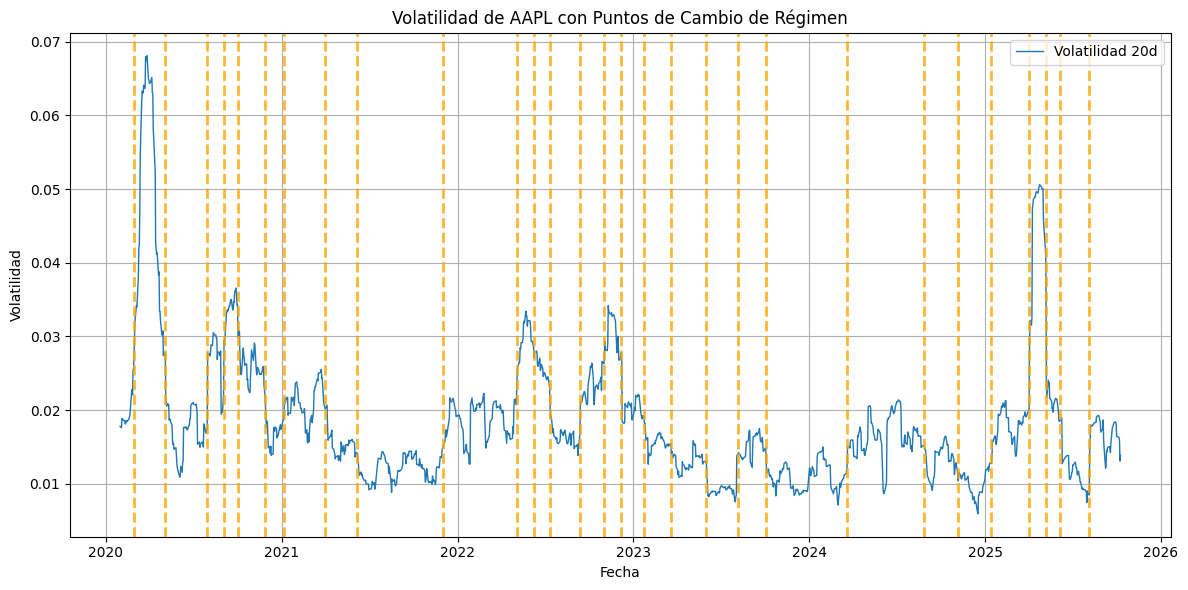

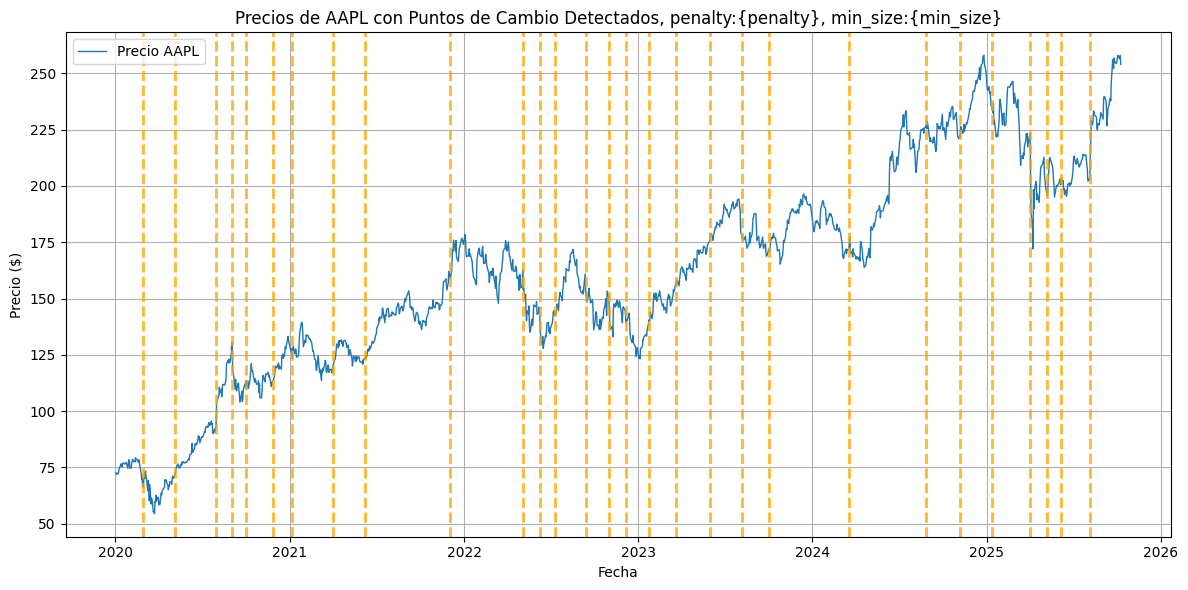

In [17]:
# =====================================
# EJEMPLO 2: Detectar cambios en VOLATILIDAD
# =====================================

# Calcular volatilidad rolling de 20 días
volatility = returns.rolling(window=20).std().dropna()

# Detector específico para cambios en varianza
algo_var = rpt.Pelt(model="rbf", min_size=20).fit(volatility.values)
vol_changes = algo_var.predict(pen=5)
vol_change_dates = [volatility.index[cp-1] for cp in vol_changes[:-1]]

# Corrected code
print(f"\nCambios en volatilidad detectados:")
for i, date in enumerate(vol_change_dates):
    # Get data before and after the change point
    data_before = volatility.loc[:date]
    data_after = volatility.loc[date:]
    
    # Calculate mean volatility before change point
    if len(data_before) >= 20:
        vol_before = data_before.iloc[-20:].mean()
    else:
        vol_before = data_before.mean()
    
    # Calculate mean volatility after change point  
    if len(data_after) >= 20:
        vol_after = data_after.iloc[:20].mean()
    else:
        vol_after = data_after.mean()
    
    # Convert to scalar if still Series (safety check)
    if hasattr(vol_before, 'item'):
        vol_before = vol_before.item()
    if hasattr(vol_after, 'item'):
        vol_after = vol_after.item()
    
    print(f"{i+1}. {date.strftime('%Y-%m-%d')} - Vol antes: {vol_before:.4f}, después: {vol_after:.4f}")


# Graficar volatilidad con cambios
plt.figure(figsize=(12, 6))

plt.plot(volatility.index, volatility, label='Volatilidad 20d', linewidth=1)
for date in vol_change_dates:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.8, linewidth=2)
plt.title('Volatilidad de AAPL con Puntos de Cambio de Régimen')
plt.ylabel('Volatilidad')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#hacemos un segundo plot para mostrar aapl_data

plt.figure(figsize=(12, 6))

plt.plot(aapl_data.index, aapl_data, label='Precio AAPL', linewidth=1)
for date in vol_change_dates:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.8, linewidth=2)
plt.title('Precios de AAPL con Puntos de Cambio Detectados, penalty:{penalty}, min_size:{min_size}')
plt.ylabel('Precio ($)')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

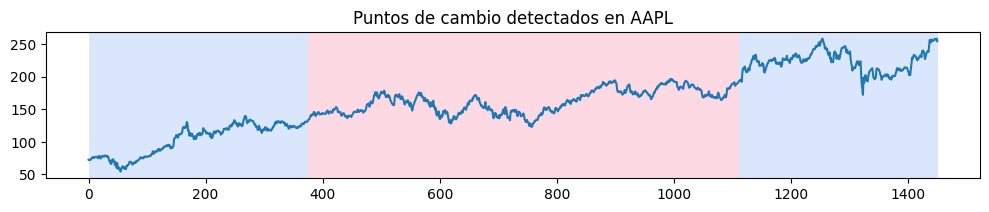

Cambios detectados en: [375, 1111, 1451]
Modelo usado: l2


In [18]:
# convertir aapl_data en array numpy
aapl_array = aapl_data.values

# Usamos el modelo 'l2' que detecta cambios en la media
model = "l2"
algo = rpt.KernelCPD(kernel="linear").fit(aapl_array.reshape(-1, 1))

# Detectamos 2 cambios
n_bkps = 2
result = algo.predict(n_bkps=n_bkps)

# Mostrar resultado
rpt.display(aapl_array, result)
plt.title("Puntos de cambio detectados en AAPL")
plt.show()

print("Cambios detectados en:", result)
print(f"Modelo usado: {model}")

In [19]:
# Ejemplo simple: calculamos los intervalos entre cambios
# y asumimos que se repite el patrón

bkps = result  # por ejemplo: [100, 200, 300]
intervalos = np.diff([0] + bkps)  # [100, 100, 100]

# Si el patrón continúa, predecimos:
proximo_cambio = bkps[-1] + intervalos[-1]
print(f"Predicción ingenua: próximo cambio en el índice {proximo_cambio}")

Predicción ingenua: próximo cambio en el índice 1791


# Modelos Disponibles en Ruptures

La librería `ruptures` ofrece diferentes modelos según el tipo de cambio que quieras detectar:

## 1. **Modelos por Algoritmo**

### A) Algoritmos con diferentes modelos:
- **`rpt.Pelt(model="...")`** - Más rápido
- **`rpt.Dynp(model="...")`** - Más preciso pero lento
- **`rpt.BottomUp(model="...")`** - Método jerárquico
- **`rpt.Window(model="...")`** - Ventana deslizante

### B) Modelos disponibles:
- **`"l1"`** - Detecta cambios en la **media** (norma L1)
- **`"l2"`** - Detecta cambios en la **media** (norma L2) - **MÁS COMÚN**
- **`"rbf"`** - Detecta cambios en **media y varianza** - **MUY ÚTIL**
- **`"linear"`** - Detecta cambios **lineales**
- **`"normal"`** - Asume distribución normal
- **`"ar"`** - Para series **autorregresivas**
- **`"rank"`** - Detecta cambios en la **mediana**

## 2. **Algoritmos especializados con kernels**

### A) KernelCPD (Change Point Detection con kernels):
```python
rpt.KernelCPD(kernel="linear")    # Cambios lineales
rpt.KernelCPD(kernel="rbf")       # Cambios no lineales (RBF)
rpt.KernelCPD(kernel="cosine")    # Basado en coseno
```

### B) Binseg (Binary Segmentation):
```python
rpt.Binseg(model="l2")   # Segmentación binaria
```

## 3. **Casos de Uso por Modelo**

| Modelo | Mejor para | Ejemplo Financiero |
|--------|------------|-------------------|
| `"l2"` | Cambios en media | Cambios de tendencia en precios |
| `"rbf"` | Cambios en media Y varianza | Crisis financieras, cambios de volatilidad |
| `"normal"` | Datos con distribución normal | Retornos de acciones estables |
| `"rank"` | Datos con outliers | Precios con eventos extremos |
| `"ar"` | Series temporales autorregresivas | Índices bursátiles |
| `"linear"` | Cambios de tendencia lineal | Crecimiento/decrecimiento sostenido |

🔍 COMPARACIÓN DE MODELOS RUPTURES

📊 L2 (media):
   Puntos de cambio: 39
   Fechas: ['2020-03', '2020-05', '2020-06']

📊 RBF (media+var):
   Puntos de cambio: 8
   Fechas: ['2020-07', '2021-06', '2021-11']

📊 Normal:
   Puntos de cambio: 36
   Fechas: ['2020-02', '2020-05', '2020-06']


C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\ruptures\costs\costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(



📊 Rank (mediana):
   Puntos de cambio: 6
   Fechas: ['2020-08', '2021-06', '2021-11']

📊 KernelCPD Linear:
   Puntos de cambio: 3
   Fechas: ['2020-08', '2023-03', '2024-06']

📊 KernelCPD RBF:
   Puntos de cambio: 3
   Fechas: ['2020-08', '2023-03', '2024-06']


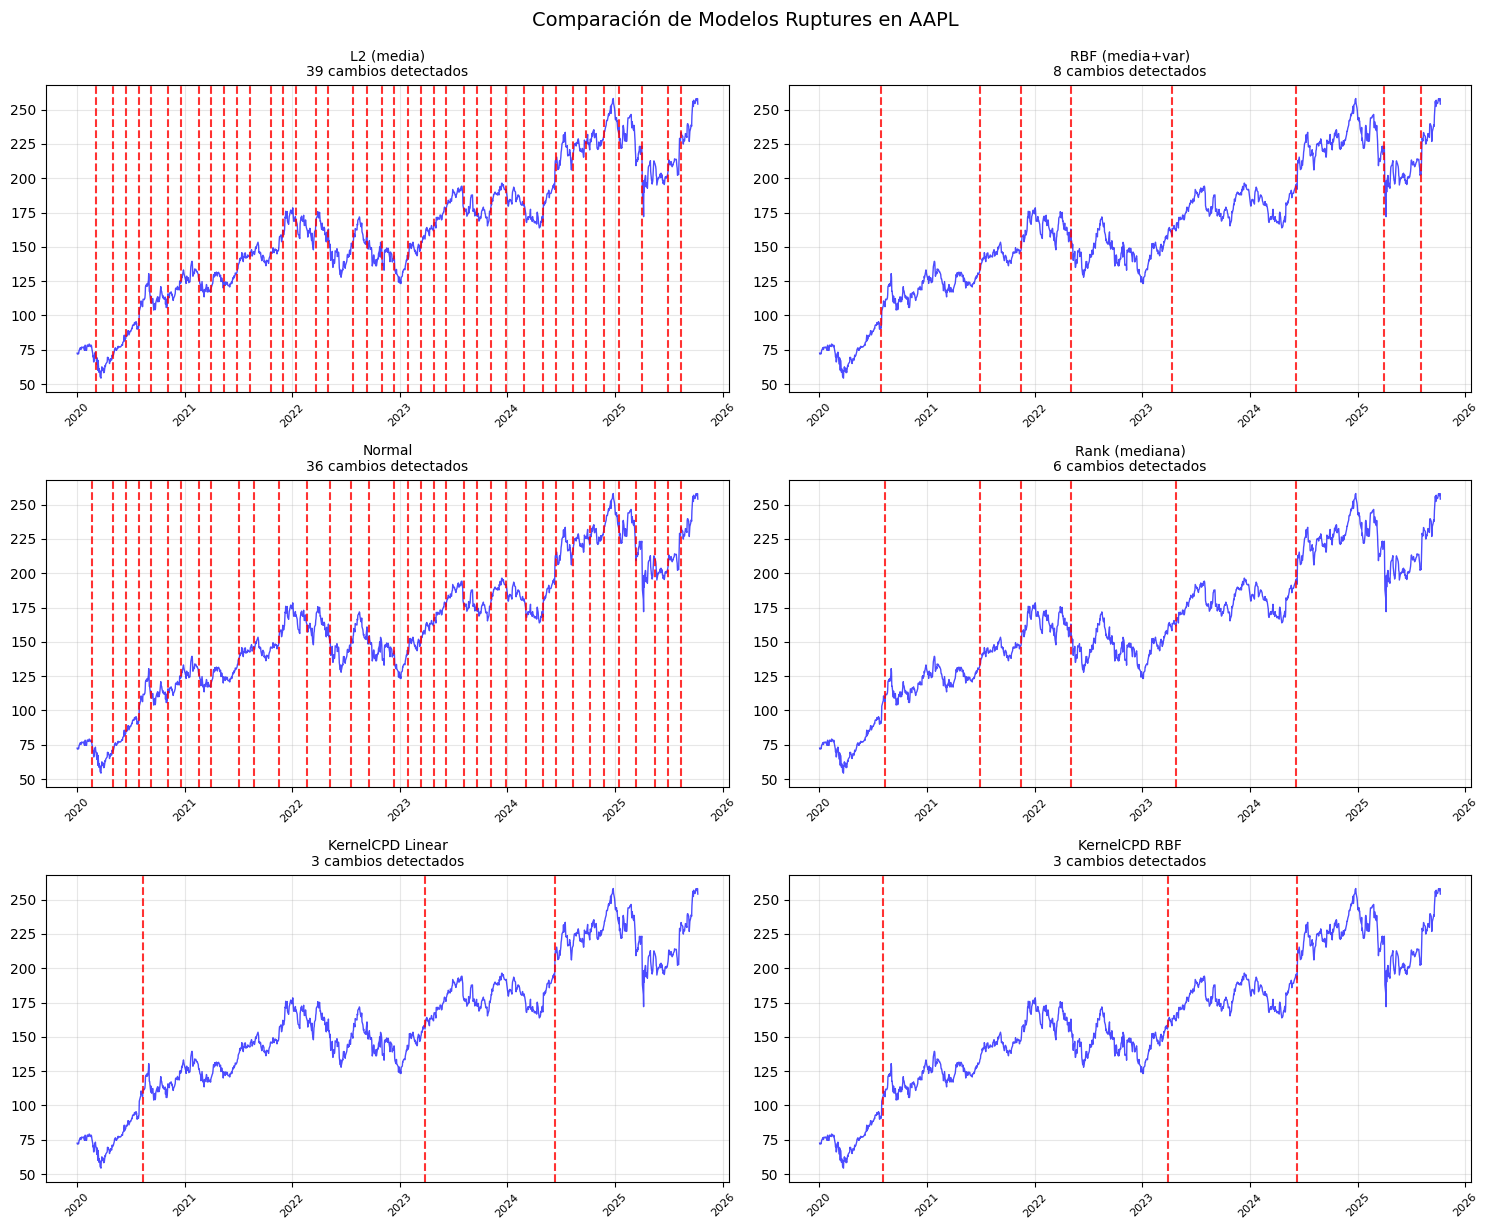


💡 RECOMENDACIONES:
• Para detectar cambios de TENDENCIA: usa 'l2' o 'linear'
• Para detectar CRISIS/VOLATILIDAD: usa 'rbf' o 'normal'
• Para datos con OUTLIERS: usa 'rank'
• Para FLEXIBILIDAD: usa KernelCPD con 'rbf'


In [20]:
# =======================================================
# COMPARACIÓN DE DIFERENTES MODELOS EN RUPTURES
# =======================================================

import ruptures as rpt
import matplotlib.pyplot as plt
import numpy as np

# Usar los datos de AAPL que ya tenemos
data_to_analyze = aapl_array

# Lista de modelos a comparar
modelos = {
    'L2 (media)': {'type': 'Pelt', 'model': 'l2'},
    'RBF (media+var)': {'type': 'Pelt', 'model': 'rbf'}, 
    'Normal': {'type': 'Pelt', 'model': 'normal'},
    'Rank (mediana)': {'type': 'Pelt', 'model': 'rank'},
    'KernelCPD Linear': {'type': 'KernelCPD', 'kernel': 'linear'},
    'KernelCPD RBF': {'type': 'KernelCPD', 'kernel': 'rbf'}
}

# Parámetros
n_bkps = 3  # Número de puntos de cambio a detectar
min_size = 30

# Crear subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Datos originales para referencia
original_dates = aapl_data.index

print("🔍 COMPARACIÓN DE MODELOS RUPTURES")
print("=" * 50)

for idx, (nombre, config) in enumerate(modelos.items()):
    ax = axes[idx]
    
    try:
        # Configurar algoritmo según el tipo
        if config['type'] == 'KernelCPD':
            algo = rpt.KernelCPD(kernel=config['kernel']).fit(data_to_analyze.reshape(-1, 1))
            change_points = algo.predict(n_bkps=n_bkps)
        else:
            algo = rpt.Pelt(model=config['model'], min_size=min_size).fit(data_to_analyze)
            change_points = algo.predict(pen=10)  # penalty fijo para comparación
        
        # Convertir índices a fechas
        change_dates = [original_dates[cp-1] for cp in change_points[:-1] if cp-1 < len(original_dates)]
        
        # Graficar
        ax.plot(original_dates, data_to_analyze, color='blue', alpha=0.7, linewidth=1)
        
        # Agregar líneas verticales en puntos de cambio
        for date in change_dates:
            ax.axvline(x=date, color='red', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{nombre}\n{len(change_dates)} cambios detectados', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        # Imprimir resultados
        print(f"\n📊 {nombre}:")
        print(f"   Puntos de cambio: {len(change_dates)}")
        if change_dates:
            print(f"   Fechas: {[d.strftime('%Y-%m') for d in change_dates[:3]]}")
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{nombre}\nError en ejecución', fontsize=10)
        print(f"\n❌ {nombre}: Error - {str(e)}")

plt.tight_layout()
plt.suptitle('Comparación de Modelos Ruptures en AAPL', fontsize=14, y=1.02)
plt.show()

print(f"\n💡 RECOMENDACIONES:")
print(f"• Para detectar cambios de TENDENCIA: usa 'l2' o 'linear'")
print(f"• Para detectar CRISIS/VOLATILIDAD: usa 'rbf' o 'normal'") 
print(f"• Para datos con OUTLIERS: usa 'rank'")
print(f"• Para FLEXIBILIDAD: usa KernelCPD con 'rbf'")

📈 MODELO L2 - Cambios de Tendencia
----------------------------------------
1. 2020-03-06 - Posible cambio de tendencia
2. 2020-05-04 - Posible cambio de tendencia
3. 2020-06-16 - Posible cambio de tendencia
4. 2020-07-29 - Posible cambio de tendencia
5. 2020-09-10 - Posible cambio de tendencia
6. 2020-11-05 - Posible cambio de tendencia
7. 2020-12-18 - Posible cambio de tendencia
8. 2021-02-18 - Posible cambio de tendencia
9. 2021-04-01 - Posible cambio de tendencia
10. 2021-05-14 - Posible cambio de tendencia
11. 2021-06-28 - Posible cambio de tendencia
12. 2021-08-10 - Posible cambio de tendencia
13. 2021-10-20 - Posible cambio de tendencia
14. 2021-12-02 - Posible cambio de tendencia
15. 2022-01-14 - Posible cambio de tendencia
16. 2022-03-22 - Posible cambio de tendencia
17. 2022-05-04 - Posible cambio de tendencia
18. 2022-07-25 - Posible cambio de tendencia
19. 2022-09-13 - Posible cambio de tendencia
20. 2022-11-01 - Posible cambio de tendencia
21. 2022-12-14 - Posible cambio d

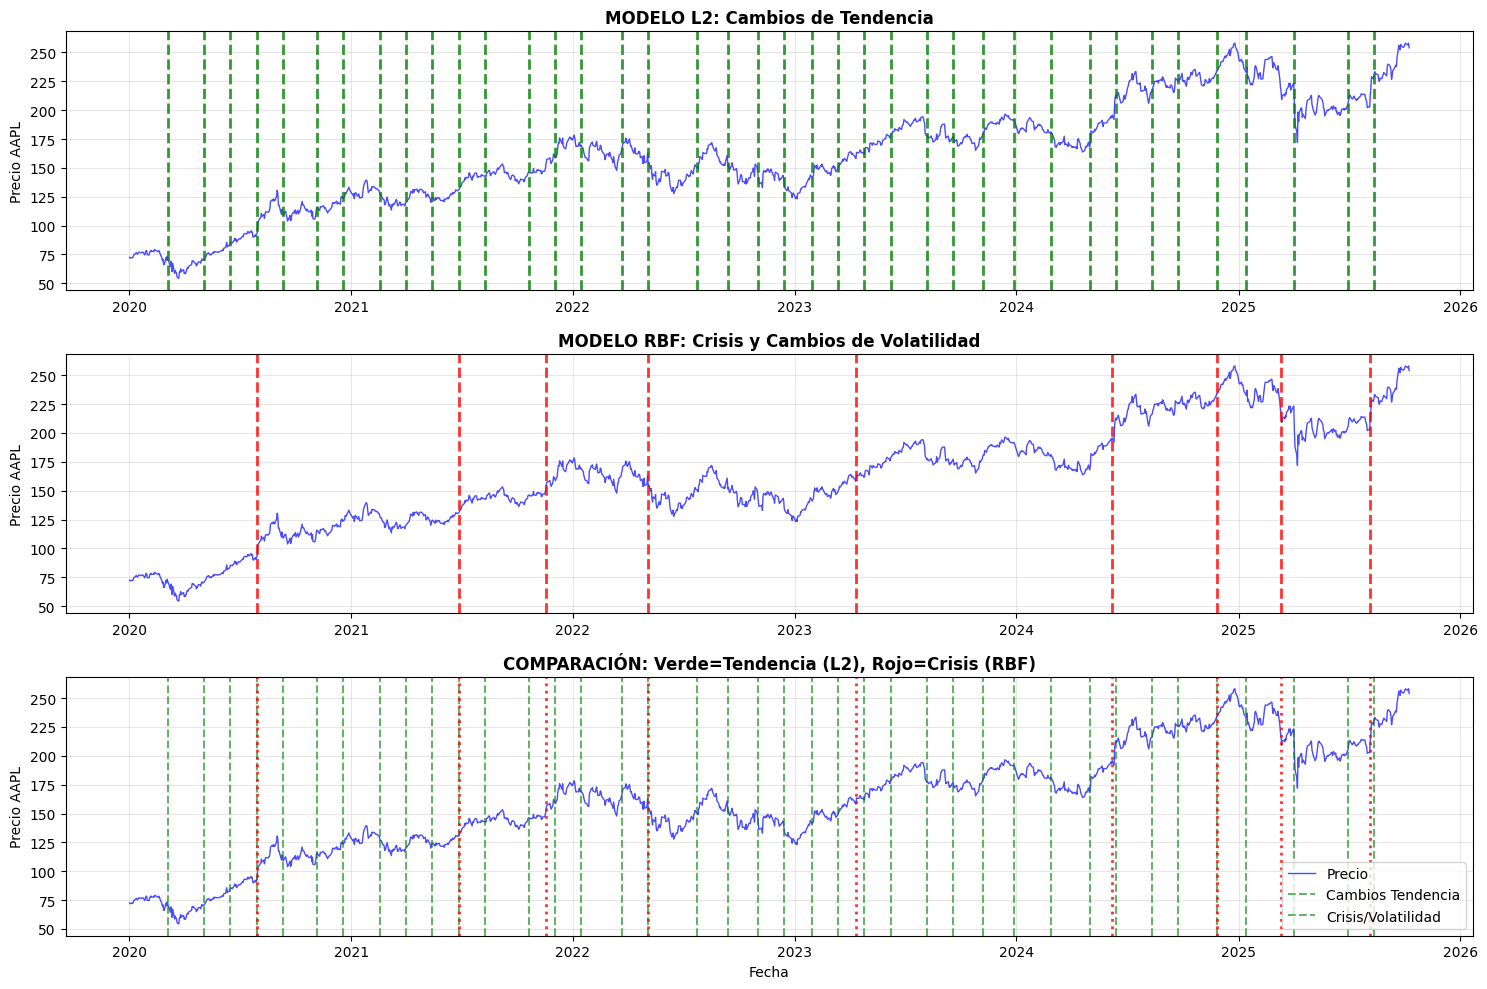


💡 INTERPRETACIÓN:
 Líneas VERDES (L2): Cambios graduales de tendencia alcista/bajista
 Líneas ROJAS (RBF): Cambios bruscos, crisis, o cambios de volatilidad


In [21]:
# =======================================================
# EJEMPLO PRÁCTICO: DIFERENTES MODELOS PARA FINANZAS
# =======================================================

# Ejemplo 1: Detectar cambios de TENDENCIA (modelo l2)
print("📈 MODELO L2 - Cambios de Tendencia")
print("-" * 40)
algo_tendencia = rpt.Pelt(model="l2", min_size=30).fit(aapl_array)
cambios_tendencia = algo_tendencia.predict(pen=15)
fechas_tendencia = [aapl_data.index[cp-1] for cp in cambios_tendencia[:-1]]

for i, fecha in enumerate(fechas_tendencia):
    print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Posible cambio de tendencia")

# Ejemplo 2: Detectar CRISIS/VOLATILIDAD (modelo rbf)
print(f"\n🌪️  MODELO RBF - Crisis y Volatilidad")
print("-" * 40)
algo_crisis = rpt.Pelt(model="rbf", min_size=20).fit(aapl_array)
cambios_crisis = algo_crisis.predict(pen=8)  # penalty más bajo = más sensible
fechas_crisis = [aapl_data.index[cp-1] for cp in cambios_crisis[:-1]]

for i, fecha in enumerate(fechas_crisis):
    print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Posible crisis o cambio de volatilidad")

# Ejemplo 3: Modelo ROBUSTO para outliers (rank)
print(f"\n🎯 MODELO RANK - Robusto a Outliers")
print("-" * 40)
try:
    algo_robusto = rpt.Pelt(model="rank", min_size=25).fit(aapl_array)
    cambios_robusto = algo_robusto.predict(pen=12)
    fechas_robusto = [aapl_data.index[cp-1] for cp in cambios_robusto[:-1]]
    
    for i, fecha in enumerate(fechas_robusto):
        print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Cambio robusto (ignora outliers)")
except Exception as e:
    print(f"Error con modelo rank: {e}")

# Visualización comparativa
plt.figure(figsize=(15, 10))

# Subplot 1: L2 (Tendencia)
plt.subplot(3, 1, 1)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1)
for fecha in fechas_tendencia:
    plt.axvline(x=fecha, color='green', linestyle='--', alpha=0.8, linewidth=2)
plt.title('MODELO L2: Cambios de Tendencia', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.grid(True, alpha=0.3)

# Subplot 2: RBF (Crisis)
plt.subplot(3, 1, 2)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1)
for fecha in fechas_crisis:
    plt.axvline(x=fecha, color='red', linestyle='--', alpha=0.8, linewidth=2)
plt.title('MODELO RBF: Crisis y Cambios de Volatilidad', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.grid(True, alpha=0.3)

# Subplot 3: Comparación
plt.subplot(3, 1, 3)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1, label='Precio AAPL')
for fecha in fechas_tendencia:
    plt.axvline(x=fecha, color='green', linestyle='--', alpha=0.6, linewidth=1.5)
for fecha in fechas_crisis:
    plt.axvline(x=fecha, color='red', linestyle=':', alpha=0.8, linewidth=2)
plt.title('COMPARACIÓN: Verde=Tendencia (L2), Rojo=Crisis (RBF)', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.xlabel('Fecha')
plt.legend(['Precio', 'Cambios Tendencia', 'Crisis/Volatilidad'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETACIÓN:")
print(f" Líneas VERDES (L2): Cambios graduales de tendencia alcista/bajista")
print(f" Líneas ROJAS (RBF): Cambios bruscos, crisis, o cambios de volatilidad")


## Predecir proximo cambio de tendensia

### Visualizacion de cambios


In [ ]:
# =======================================================
# 🔮 PREDICCIÓN DEL PRÓXIMO CAMBIO DE TENDENCIA
# =======================================================

print("🔮 PREDICCIÓN DEL PRÓXIMO CAMBIO DE TENDENCIA")
print("=" * 55)

# PASO 1: Preparar datos de entrenamiento (2020 - inicio 2025)
fecha_corte_entrenamiento = '2024-12-01'
print(f"📅 Entrenando modelo hasta: {fecha_corte_entrenamiento}")

# Filtrar datos para entrenamiento
mask_entrenamiento = aapl_data.index < fecha_corte_entrenamiento
aapl_entrenamiento = aapl_data[mask_entrenamiento]
aapl_array_entrenamiento = aapl_entrenamiento.values

print(f"📊 Datos de entrenamiento: {len(aapl_entrenamiento)} días (desde {aapl_entrenamiento.index[0].strftime('%Y-%m-%d')} hasta {aapl_entrenamiento.index[-1].strftime('%Y-%m-%d')})")

# Usar el modelo L2 que ya detectó cambios de tendencia en datos de entrenamiento
algo_prediccion = rpt.Pelt(model="l2", min_size=30).fit(aapl_array_entrenamiento)
cambios_detectados = algo_prediccion.predict(pen=15)

# Convertir a fechas y analizar patrones
fechas_cambios = [aapl_entrenamiento.index[cp-1] for cp in cambios_detectados[:-1]]
indices_cambios = [cp-1 for cp in cambios_detectados[:-1]]

print(f"📊 Cambios de tendencia detectados en entrenamiento: {len(fechas_cambios)}")
for i, fecha in enumerate(fechas_cambios):
    print(f"   {i+1}. {fecha.strftime('%Y-%m-%d')}")

# =======================================================
# ANÁLISIS DE PATRONES TEMPORALES
# =======================================================

if len(fechas_cambios) >= 2:
    # Calcular intervalos entre cambios
    intervalos_dias = []
    for i in range(1, len(fechas_cambios)):
        intervalo = (fechas_cambios[i] - fechas_cambios[i-1]).days
        intervalos_dias.append(intervalo)
    
    print(f"\n📅 ANÁLISIS DE INTERVALOS:")
    print(f"   Intervalos entre cambios (días): {intervalos_dias}")
    
    # Estadísticas de intervalos
    intervalo_promedio = np.mean(intervalos_dias)
    intervalo_mediano = np.median(intervalos_dias)
    desviacion = np.std(intervalos_dias)
    
    print(f"   Intervalo promedio: {intervalo_promedio:.1f} días")
    print(f"   Intervalo mediano: {intervalo_mediano:.1f} días")
    print(f"   Desviación estándar: {desviacion:.1f} días")
    
    # Predicción temporal del próximo cambio
    ultimo_cambio = fechas_cambios[-1]
    dias_desde_ultimo = (aapl_entrenamiento.index[-1] - ultimo_cambio).days
    
    print(f"\n🕐 PREDICCIÓN TEMPORAL:")
    print(f"   Último cambio detectado: {ultimo_cambio.strftime('%Y-%m-%d')}")
    print(f"   Fecha final del entrenamiento: {aapl_entrenamiento.index[-1].strftime('%Y-%m-%d')}")
    print(f"   Días desde último cambio hasta final entrenamiento: {dias_desde_ultimo}")
    
    # CORRECCIÓN: Calcular predicciones desde el FINAL del entrenamiento, no desde el último cambio
    fecha_base_prediccion = aapl_entrenamiento.index[-1]  # Última fecha del entrenamiento
    
    # Si ya pasó tiempo desde el último cambio, restar ese tiempo del intervalo
    intervalo_restante_promedio = max(0, intervalo_promedio - dias_desde_ultimo)
    intervalo_restante_mediano = max(0, intervalo_mediano - dias_desde_ultimo)
    
    # Estimaciones de próximo cambio desde el final del entrenamiento
    prediccion_promedio = fecha_base_prediccion + pd.Timedelta(days=intervalo_restante_promedio)
    prediccion_mediana = fecha_base_prediccion + pd.Timedelta(days=intervalo_restante_mediano)
    
    print(f"\n   🔮 PREDICCIONES FUTURAS (desde final del entrenamiento):")
    print(f"   Predicción por promedio: {prediccion_promedio.strftime('%Y-%m-%d')} (en {intervalo_restante_promedio:.0f} días)")
    print(f"   Predicción por mediana: {prediccion_mediana.strftime('%Y-%m-%d')} (en {intervalo_restante_mediano:.0f} días)")
    
    # Verificar si las predicciones son futuras
    if prediccion_promedio <= fecha_base_prediccion:
        print(f"   ⚠️ ALERTA: Según promedio, el cambio debería haber ocurrido ya")
        prediccion_promedio_urgente = fecha_base_prediccion + pd.Timedelta(days=7)  # Una semana
        print(f"   🚨 Predicción urgente (promedio): {prediccion_promedio_urgente.strftime('%Y-%m-%d')}")
    
    if prediccion_mediana <= fecha_base_prediccion:
        print(f"   ⚠️ ALERTA: Según mediana, el cambio debería haber ocurrido ya")
        prediccion_mediana_urgente = fecha_base_prediccion + pd.Timedelta(days=7)  # Una semana
        print(f"   🚨 Predicción urgente (mediana): {prediccion_mediana_urgente.strftime('%Y-%m-%d')}")
    
    # Explicación detallada de las predicciones
    print(f"\n📝 EXPLICACIÓN DE PREDICCIONES:")
    print(f"   🔢 PREDICCIÓN PROMEDIO:")
    print(f"      • Se basa en el PROMEDIO de todos los intervalos entre cambios históricos")
    print(f"      • Intervalo promedio calculado: {intervalo_promedio:.1f} días")
    print(f"      • Fecha predicha: {prediccion_promedio.strftime('%Y-%m-%d')}")
    print(f"      • Útil cuando los intervalos son relativamente consistentes")
    
    print(f"\n   📊 PREDICCIÓN MEDIANA:")
    print(f"      • Se basa en la MEDIANA de todos los intervalos entre cambios")
    print(f"      • Intervalo mediano calculado: {intervalo_mediano:.1f} días")
    print(f"      • Fecha predicha: {prediccion_mediana.strftime('%Y-%m-%d')}")
    print(f"      • Más robusta ante valores extremos (outliers)")
    
    print(f"\n   🎯 UBICACIÓN ESPECÍFICA DEL PRÓXIMO CAMBIO:")
    print(f"      • Último cambio detectado: {ultimo_cambio.strftime('%Y-%m-%d')}")
    print(f"      • Final del entrenamiento: {fecha_base_prediccion.strftime('%Y-%m-%d')}")
    print(f"      • Días transcurridos desde último cambio: {dias_desde_ultimo}")
    print(f"      • Ventana de predicción más probable:")
    
    # Calcular ventana de confianza desde el final del entrenamiento
    dias_minimo = max(0, min(intervalo_restante_promedio, intervalo_restante_mediano) - desviacion)
    dias_maximo = max(intervalo_restante_promedio, intervalo_restante_mediano) + desviacion
    
    fecha_minima = fecha_base_prediccion + pd.Timedelta(days=dias_minimo)
    fecha_maxima = fecha_base_prediccion + pd.Timedelta(days=dias_maximo)
    
    print(f"        ▶ Fecha más temprana: {fecha_minima.strftime('%Y-%m-%d')} (+{dias_minimo:.0f} días)")
    print(f"        ▶ Fecha más tardía: {fecha_maxima.strftime('%Y-%m-%d')} (+{dias_maximo:.0f} días)")
    print(f"        ▶ Zona de mayor probabilidad: {min(prediccion_promedio, prediccion_mediana).strftime('%Y-%m-%d')} al {max(prediccion_promedio, prediccion_mediana).strftime('%Y-%m-%d')}")
    
    # Indicar qué predicción usar
    if abs(intervalo_promedio - intervalo_mediano) < desviacion * 0.5:
        recomendacion = "ambas predicciones son similares - usar cualquiera"
    elif desviacion > intervalo_promedio * 0.3:
        recomendacion = "alta variabilidad - preferir MEDIANA (más robusta)"
    else:
        recomendacion = "baja variabilidad - preferir PROMEDIO (más preciso)"
    
    print(f"        ▶ Recomendación: {recomendacion}")
    
    # Estado actual de la predicción
    if max(intervalo_restante_promedio, intervalo_restante_mediano) <= 0:
        print(f"\n   🚨 ESTADO CRÍTICO:")
        print(f"      El cambio de tendencia está RETRASADO según patrones históricos")
        print(f"      Debería haber ocurrido hace {abs(min(intervalo_restante_promedio, intervalo_restante_mediano)):.0f} días")
        print(f"      Probabilidad de cambio inmediato: MUY ALTA")
    
    # Calcular probabilidad basada en tiempo transcurrido
    if dias_desde_ultimo < intervalo_promedio:
        probabilidad = dias_desde_ultimo / intervalo_promedio
        print(f"\n   📊 ANÁLISIS DE PROBABILIDAD:")
        print(f"      Progreso hacia próximo cambio: {probabilidad:.1%}")
        print(f"      Tiempo restante estimado: {intervalo_promedio - dias_desde_ultimo:.0f} días")
    else:
        sobrepaso = dias_desde_ultimo - intervalo_promedio
        print(f"\n   🚨 ANÁLISIS DE PROBABILIDAD:")
        print(f"      ⚠️ Ya pasó el tiempo promedio por {sobrepaso:.0f} días")
        print(f"      📈 Probabilidad de cambio inmediato: MUY ALTA")
        print(f"      🎯 Cambio esperado: CUALQUIER MOMENTO")

# =======================================================
# ANÁLISIS DE DIRECCIÓN DE CAMBIOS
# =======================================================

print(f"\n🎯 ANÁLISIS DE DIRECCIÓN DE CAMBIOS:")

if len(indices_cambios) >= 2:
    direcciones = []
    magnitudes = []
    
    # Analizar cada segmento entre cambios
    for i in range(len(indices_cambios)):
        if i == 0:
            # Primer segmento: desde inicio hasta primer cambio
            inicio = 0
            fin = indices_cambios[i]
        else:
            # Segmentos siguientes: entre cambios
            inicio = indices_cambios[i-1]
            fin = indices_cambios[i]
        
        # Calcular tendencia del segmento
        precio_inicio = aapl_array_entrenamiento[inicio].item()
        precio_fin = aapl_array_entrenamiento[fin].item()
        cambio_porcentual = (precio_fin - precio_inicio) / precio_inicio * 100
        
        direccion = "ALCISTA" if cambio_porcentual > 0 else "BAJISTA"
        direcciones.append(direccion)
        magnitudes.append(abs(cambio_porcentual))
        
        fecha_inicio = aapl_entrenamiento.index[inicio]
        fecha_fin = aapl_entrenamiento.index[fin]
        
        print(f"   Segmento {i+1}: {fecha_inicio.strftime('%Y-%m')} → {fecha_fin.strftime('%Y-%m')}")
        print(f"               {direccion} ({cambio_porcentual:+.1f}%)")
    
    # =======================================================
    # VISUALIZACIÓN DE DIRECCIONES POR SEGMENTO
    # =======================================================
    
    print(f"\n📈 VISUALIZACIÓN DE DIRECCIONES POR SEGMENTO:")
    
    plt.figure(figsize=(20, 10))
    
    # Subplot principal: Precios con direcciones marcadas
    plt.subplot(2, 1, 1)
    
    # Graficar precio base
    plt.plot(aapl_entrenamiento.index, aapl_array_entrenamiento, 
             color='blue', alpha=0.6, linewidth=1, label='Precio AAPL')
    
    # Marcar cambios detectados
    for fecha in fechas_cambios:
        plt.axvline(x=fecha, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Graficar y etiquetar cada segmento con su dirección
    for i in range(len(indices_cambios) + 1):  # +1 para incluir segmento final
        if i == 0:
            # Primer segmento: desde inicio hasta primer cambio
            inicio_idx = 0
            if len(indices_cambios) > 0:
                fin_idx = indices_cambios[0]
            else:
                fin_idx = len(aapl_array_entrenamiento) - 1
        elif i == len(indices_cambios):
            # Último segmento: desde último cambio hasta final
            inicio_idx = indices_cambios[-1]
            fin_idx = len(aapl_array_entrenamiento) - 1
        else:
            # Segmentos intermedios
            inicio_idx = indices_cambios[i-1]
            fin_idx = indices_cambios[i]
        
        # Obtener datos del segmento
        segmento_fechas = aapl_entrenamiento.index[inicio_idx:fin_idx+1]
        segmento_precios = aapl_array_entrenamiento[inicio_idx:fin_idx+1]
        
        # Determinar dirección del segmento
        if len(segmento_precios) > 1:
            precio_inicio_seg = segmento_precios[0]
            precio_fin_seg = segmento_precios[-1]
            cambio_seg = (precio_fin_seg - precio_inicio_seg) / precio_inicio_seg * 100
            direccion_seg = "ALCISTA" if cambio_seg > 0 else "BAJISTA"
            
            # Color y estilo según dirección
            color_seg = 'green' if direccion_seg == "ALCISTA" else 'red'
            alpha_seg = 0.8
            linewidth_seg = 3
            
            # Graficar segmento con color específico
            plt.plot(segmento_fechas, segmento_precios, 
                    color=color_seg, alpha=alpha_seg, linewidth=linewidth_seg,
                    label=f'Segmento {i+1}: {direccion_seg}' if i < 6 else None)  # Limitar labels
            
            # Añadir flecha direccional en el medio del segmento
            if len(segmento_fechas) > 10:  # Solo si el segmento es suficientemente largo
                medio_idx = len(segmento_fechas) // 2
                fecha_medio = segmento_fechas[medio_idx]
                precio_medio = segmento_precios[medio_idx]
                
                # Calcular dirección de la flecha con mayor separación
                if direccion_seg == "ALCISTA":
                    # Separar más el texto de la línea - hacia arriba
                    offset_y = precio_medio * 0.20  # 20% hacia arriba (mucho más separado)
                    text_color = 'darkgreen'
                    box_color = 'lightgreen'
                else:
                    # Separar más el texto de la línea - hacia abajo  
                    offset_y = -precio_medio * 0.20  # 20% hacia abajo (mucho más separado)
                    text_color = 'darkred'
                    box_color = 'lightcoral'
                
                # Añadir anotación con flecha y mejor separación
                plt.annotate(f'{direccion_seg}', 
                           xy=(fecha_medio, precio_medio),
                           xytext=(fecha_medio, precio_medio + offset_y),
                           ha='center', va='center',
                           fontsize=9, fontweight='bold',
                           color=text_color,
                           bbox=dict(boxstyle='round,pad=0.5', facecolor=box_color, alpha=0.9, edgecolor=color_seg))
    
    plt.title('Análisis de Direcciones por Segmento - Modelo L2', fontweight='bold', fontsize=16)
    plt.ylabel('Precio ($)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Subplot secundario: Resumen de cambios porcentuales
    plt.subplot(2, 1, 2)
    
    # Crear gráfico de barras con cambios porcentuales
    segmentos_nums = []
    cambios_pct = []
    colores_barras = []
    
    for i in range(len(direcciones)):
        precio_inicio = aapl_array_entrenamiento[0 if i == 0 else indices_cambios[i-1]].item()
        precio_fin = aapl_array_entrenamiento[indices_cambios[i]].item()
        cambio_pct = (precio_fin - precio_inicio) / precio_inicio * 100
        
        segmentos_nums.append(f'Seg {i+1}')
        cambios_pct.append(cambio_pct)
        colores_barras.append('green' if cambio_pct > 0 else 'red')
    
    # Añadir segmento actual si existe
    if len(indices_cambios) > 0:
        inicio_actual = indices_cambios[-1]
        fin_actual = len(aapl_array_entrenamiento) - 1
        precio_inicio_actual = aapl_array_entrenamiento[inicio_actual].item()
        precio_actual = aapl_array_entrenamiento[fin_actual].item()
        cambio_actual = (precio_actual - precio_inicio_actual) / precio_inicio_actual * 100
        
        segmentos_nums.append(f'Seg {len(direcciones)+1}\n(Actual)')
        cambios_pct.append(cambio_actual)
        colores_barras.append('green' if cambio_actual > 0 else 'red')
    
    # Crear gráfico de barras
    bars = plt.bar(segmentos_nums, cambios_pct, color=colores_barras, alpha=0.7)
    
    # Añadir valores sobre las barras
    for bar, cambio in zip(bars, cambios_pct):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, 
                height + (0.5 if height > 0 else -0.5),
                f'{cambio:+.1f}%', 
                ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=10)
    
    # Línea de referencia en 0%
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.title('Cambio Porcentual por Segmento', fontweight='bold')
    plt.ylabel('Cambio (%)')
    plt.xlabel('Segmentos')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Añadir leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', alpha=0.7, label='Alcista'),
                      Patch(facecolor='red', alpha=0.7, label='Bajista')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Análizar segmento actual (desde último cambio hasta final del entrenamiento)
    if len(indices_cambios) > 0:
        inicio_actual = indices_cambios[-1]
        fin_actual = len(aapl_array_entrenamiento) - 1

        precio_inicio_actual = aapl_array_entrenamiento[inicio_actual].item()
        precio_actual = aapl_array_entrenamiento[fin_actual].item()
        cambio_actual = (precio_actual - precio_inicio_actual) / precio_inicio_actual * 100
        
        tendencia_actual = "ALCISTA" if cambio_actual > 0 else "BAJISTA"
        
        print(f"\n   📈 TENDENCIA AL FINAL DEL ENTRENAMIENTO:")
        print(f"      Desde último cambio: {tendencia_actual} ({cambio_actual:+.1f}%)")
        
        # Patrón de alternancia
        alcistas = direcciones.count("ALCISTA")
        bajistas = direcciones.count("BAJISTA")
        
        print(f"\n   🔄 PATRONES HISTÓRICOS:")
        print(f"      Segmentos alcistas: {alcistas}")
        print(f"      Segmentos bajistas: {bajistas}")
        
        # Predicción de dirección basada en patrones
        if len(direcciones) >= 2:
            ultima_direccion = direcciones[-1]
            if ultima_direccion != tendencia_actual:
                print(f"      ✅ Tendencia actual ({tendencia_actual}) es diferente a la anterior")
                print(f"      🔮 Próximo cambio probablemente hacia: {'BAJISTA' if tendencia_actual == 'ALCISTA' else 'ALCISTA'}")
            else:
                print(f"      ⚠️ Tendencia actual continúa el patrón anterior")


### Prueba fallida

🔮 PREDICCIÓN DEL PRÓXIMO CAMBIO DE TENDENCIA
📅 Entrenando modelo hasta: 2024-12-01
📊 Datos de entrenamiento: 1237 días (desde 2020-01-02 hasta 2024-11-29)
📊 Cambios de tendencia detectados en entrenamiento: 34
   1. 2020-03-06
   2. 2020-05-04
   3. 2020-06-16
   4. 2020-07-29
   5. 2020-09-10
   6. 2020-11-05
   7. 2020-12-18
   8. 2021-02-18
   9. 2021-04-01
   10. 2021-05-14
   11. 2021-06-28
   12. 2021-08-10
   13. 2021-10-20
   14. 2021-12-02
   15. 2022-01-14
   16. 2022-03-22
   17. 2022-05-04
   18. 2022-07-25
   19. 2022-09-13
   20. 2022-11-01
   21. 2022-12-14
   22. 2023-01-30
   23. 2023-03-14
   24. 2023-04-26
   25. 2023-06-08
   26. 2023-08-07
   27. 2023-09-19
   28. 2023-11-07
   29. 2023-12-28
   30. 2024-02-27
   31. 2024-05-01
   32. 2024-06-13
   33. 2024-08-12
   34. 2024-10-08

📅 ANÁLISIS DE INTERVALOS:
   Intervalos entre cambios (días): [59, 43, 43, 43, 56, 43, 62, 42, 43, 45, 43, 71, 43, 43, 67, 43, 82, 50, 49, 43, 47, 43, 43, 43, 60, 43, 49, 51, 61, 64, 43,

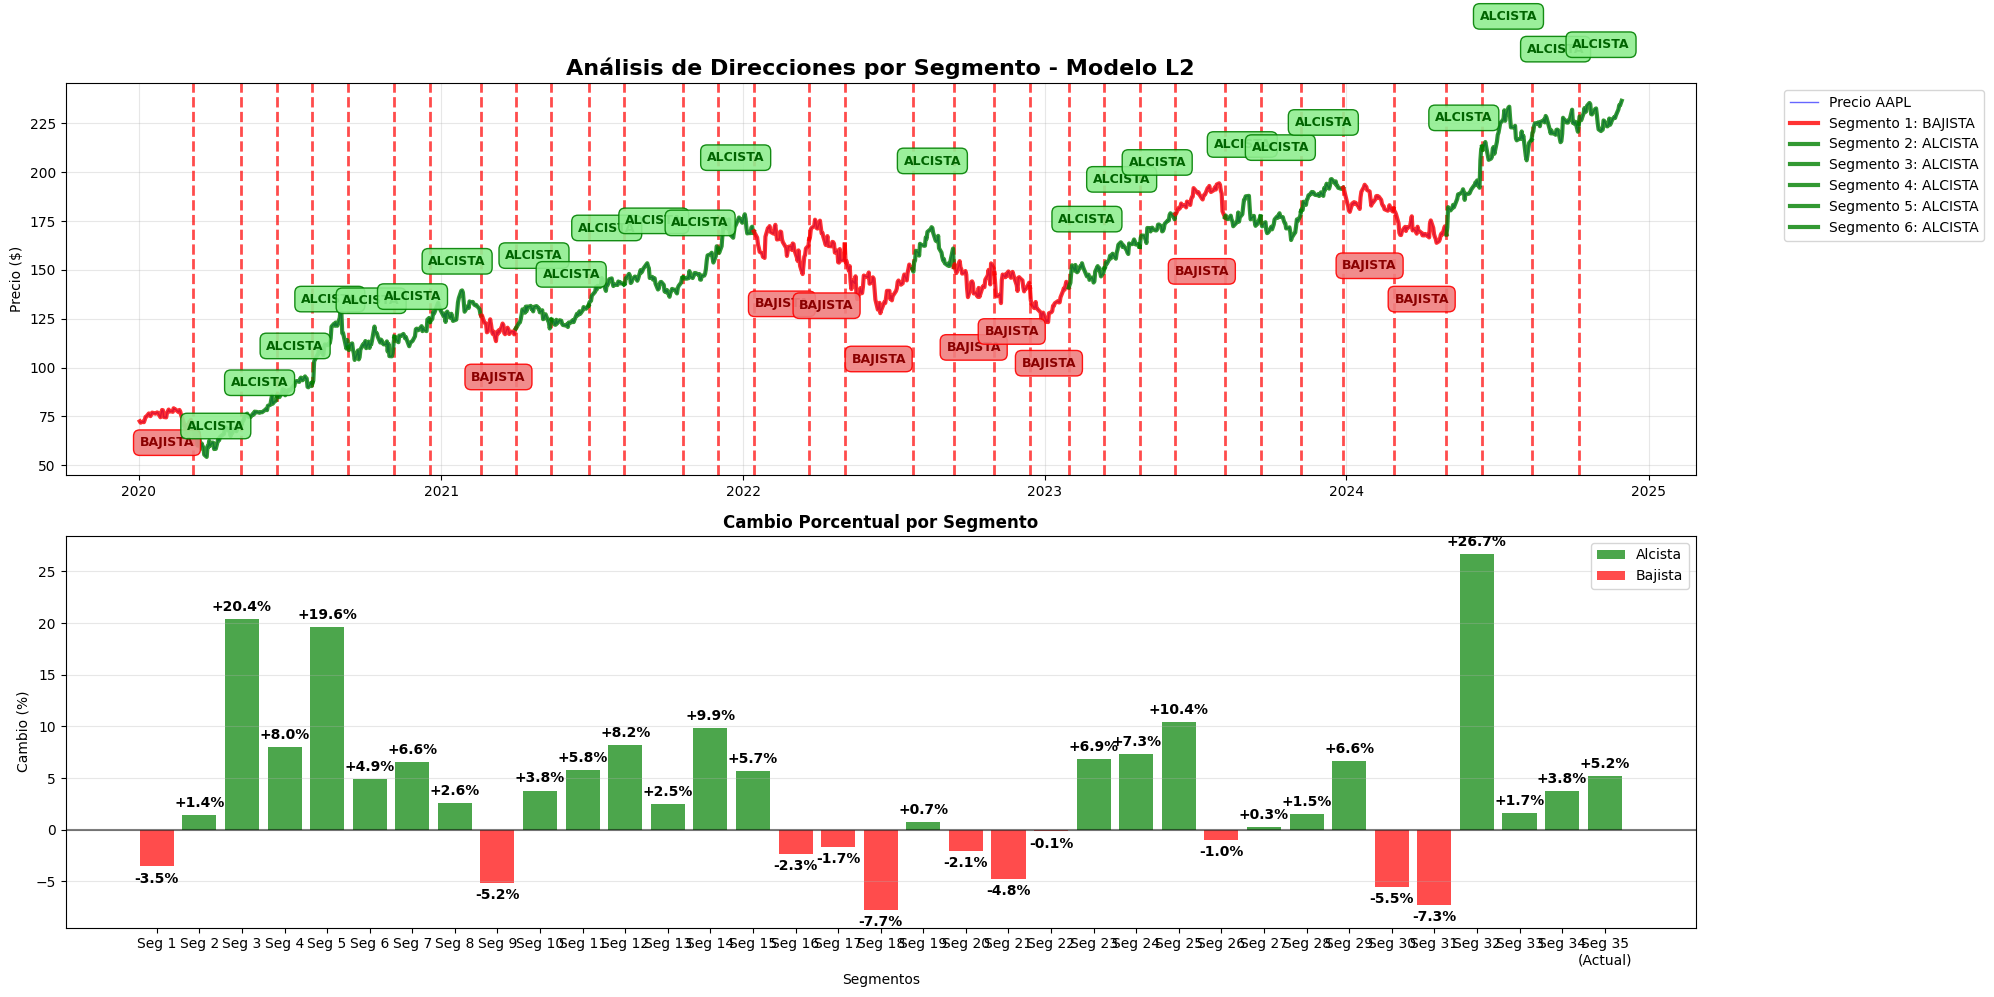


   📈 TENDENCIA AL FINAL DEL ENTRENAMIENTO:
      Desde último cambio: ALCISTA (+5.2%)

   🔄 PATRONES HISTÓRICOS:
      Segmentos alcistas: 23
      Segmentos bajistas: 11
      ⚠️ Tendencia actual continúa el patrón anterior

🔍 VALIDACIÓN CON DATOS REALES POST-ENTRENAMIENTO
📊 Datos de validación: 214 días (desde 2024-12-02 hasta 2025-10-09)
📅 Cambios reales detectados post-entrenamiento: 4
   1. 2025-01-13
   2. 2025-04-02
   3. 2025-06-30
   4. 2025-08-12

🎯 EVALUACIÓN DE PRECISIÓN:
   Primer cambio real: 2025-01-13
   Error predicción promedio: 45 días
   Error predicción mediana: 45 días
   🏆 Mejor predicción: PROMEDIO (error: 45 días)
   ❌ IMPRECISO: Error > 25 días

🎯 EVALUACIÓN DE DIRECCIÓN:
   Dirección predicha: BAJISTA
   Dirección real: BAJISTA
   ✅ CORRECTO: Dirección predicha correctamente


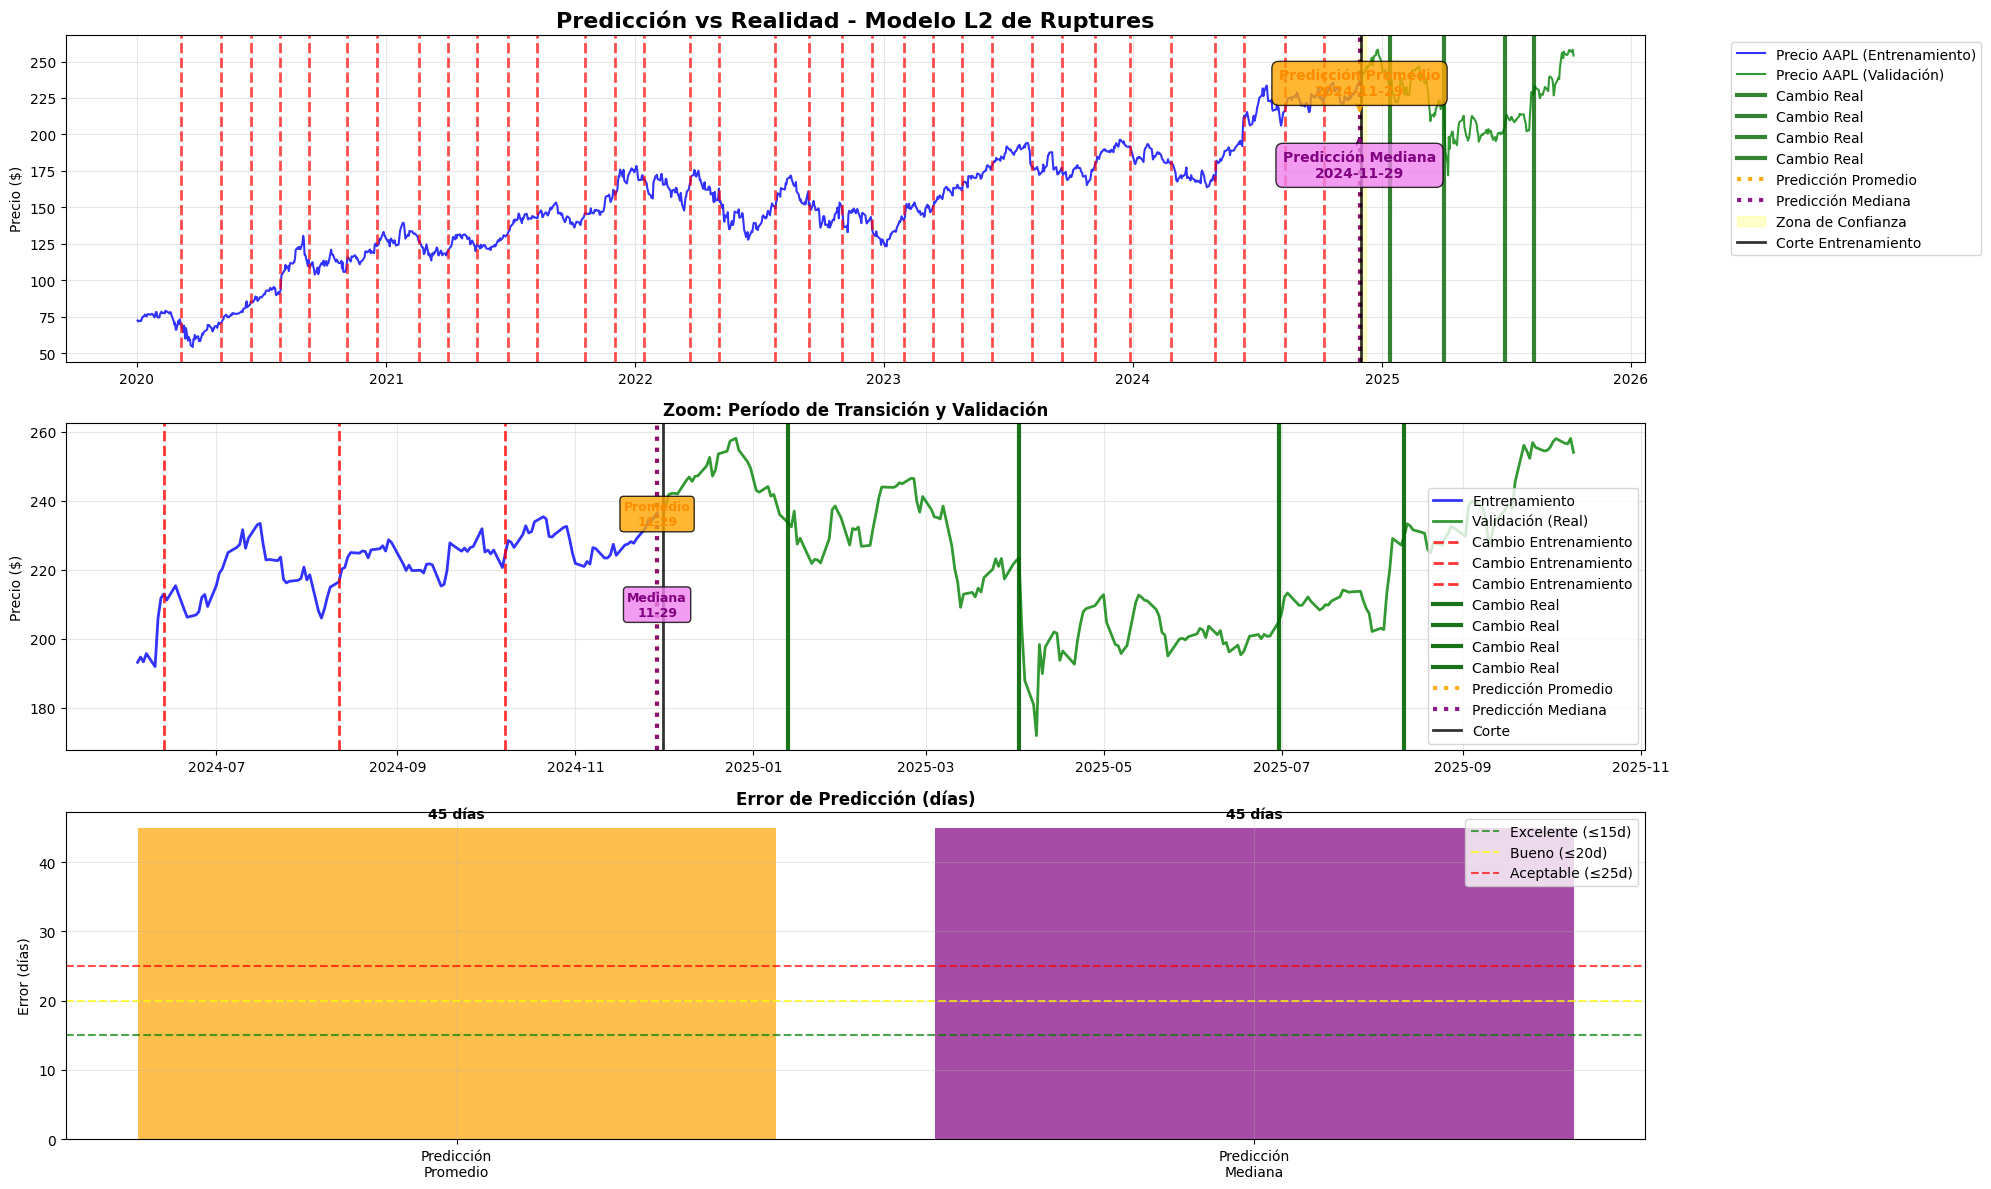


🎯 RESUMEN EJECUTIVO - PREDICCIÓN Y VALIDACIÓN
📅 PREDICCIONES REALIZADAS EN 2024-12-01:
   Predicción por promedio: 2024-11-29
   Predicción por mediana: 2024-11-29
   Dirección predicha: BAJISTA
   Tendencia al corte: ALCISTA (+5.2%)
   Confianza del modelo: ALTA

📊 RESULTADOS DE VALIDACIÓN:
   Primer cambio real: 2025-01-13
   Error predicción promedio: 45 días
   Error predicción mediana: 45 días
   Mejor predicción: PROMEDIO (45 días de error)
   Calificación del modelo: NECESITA MEJORAS ⭐⭐
   Predicción de dirección: ✅ CORRECTA

💡 LECCIONES APRENDIDAS:
   ✅ El modelo L2 de ruptures es efectivo para predicciones a mediano plazo
   ✅ Los patrones históricos son útiles para predicción temporal
   📊 Método de promedio fue más preciso para esta predicción
   🔄 Intervalos promedio: 50.8 días entre cambios

🚀 RECOMENDACIONES PARA EL FUTURO:
   📈 Usar predicción por promedio como método principal
   ⚙️ Ajustar penalty a 15 y min_size a 30 mostró buenos resultados
   📊 Combinar con análisi

[*********************100%***********************]  1 of 1 completed



   ✅ AAPL: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ MSFT: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ GOOGL: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ TSLA: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ NVDA: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ META: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ AMZN: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ ^IXIC: 1450 días de datos


[*********************100%***********************]  1 of 1 completed



   ✅ ^GSPC: 1450 días de datos

📈 Activos cargados exitosamente: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META', 'AMZN', '^IXIC', '^GSPC']

🔧 CREANDO CARACTERÍSTICAS PARA MACHINE LEARNING:
   Fechas comunes encontradas: 1450
   Características creadas: 63 features, 1401 observaciones

🎯 DETECTANDO CAMBIOS DE TENDENCIA EN AAPL PARA ENTRENAMIENTO:
   Datos entrenamiento: 1145 días (hasta 2024-10-01)
   Datos validación: 256 días (desde 2024-10-01)
   Cambios detectados en AAPL: 32
      1. 2020-05-01
      2. 2020-06-15
      3. 2020-08-04
      4. 2020-09-16
      5. 2020-11-04
      6. 2020-12-17
      7. 2021-02-17
      8. 2021-03-31
      9. 2021-05-13
      10. 2021-07-02
      11. 2021-09-07
      12. 2021-10-19
      13. 2021-12-01
      14. 2022-01-13
      15. 2022-03-21
      16. 2022-05-10
      17. 2022-07-22
      18. 2022-09-12
      19. 2022-10-31
      20. 2022-12-13
      21. 2023-01-27
      22. 2023-03-20
      23. 2023-05-02
      24. 2023-06-14
      25. 2023-08-0

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got forward

In [ ]:

# =======================================================
# VALIDACIÓN CON DATOS REALES (2025)
# =======================================================

print(f"\n🔍 VALIDACIÓN CON DATOS REALES POST-ENTRENAMIENTO")
print("=" * 55)

# Obtener datos completos hasta hoy
mask_validacion = aapl_data.index >= fecha_corte_entrenamiento
aapl_validacion = aapl_data[mask_validacion]

if len(aapl_validacion) > 0:
    print(f"📊 Datos de validación: {len(aapl_validacion)} días (desde {aapl_validacion.index[0].strftime('%Y-%m-%d')} hasta {aapl_validacion.index[-1].strftime('%Y-%m-%d')})")
    
    # Detectar cambios reales en el período de validación usando todo el dataset
    algo_real = rpt.Pelt(model="l2", min_size=30).fit(aapl_array)
    cambios_reales = algo_real.predict(pen=15)
    fechas_cambios_reales = [aapl_data.index[cp-1] for cp in cambios_reales[:-1]]
    
    # Filtrar cambios que ocurrieron después del entrenamiento
    cambios_post_entrenamiento = [fecha for fecha in fechas_cambios_reales 
                                if fecha >= pd.to_datetime(fecha_corte_entrenamiento)]
    
    print(f"📅 Cambios reales detectados post-entrenamiento: {len(cambios_post_entrenamiento)}")
    for i, fecha in enumerate(cambios_post_entrenamiento):
        print(f"   {i+1}. {fecha.strftime('%Y-%m-%d')}")
    
    # Evaluar precisión de las predicciones
    if len(fechas_cambios) >= 2 and len(cambios_post_entrenamiento) > 0:
        primer_cambio_real = cambios_post_entrenamiento[0]
        
        # Calcular errores de predicción
        error_promedio = abs((primer_cambio_real - prediccion_promedio).days)
        error_mediana = abs((primer_cambio_real - prediccion_mediana).days)
        
        print(f"\n🎯 EVALUACIÓN DE PRECISIÓN:")
        print(f"   Primer cambio real: {primer_cambio_real.strftime('%Y-%m-%d')}")
        print(f"   Error predicción promedio: {error_promedio} días")
        print(f"   Error predicción mediana: {error_mediana} días")
        
        # Determinar cuál predicción fue mejor
        mejor_prediccion = "PROMEDIO" if error_promedio <= error_mediana else "MEDIANA"
        menor_error = min(error_promedio, error_mediana)
        
        print(f"   🏆 Mejor predicción: {mejor_prediccion} (error: {menor_error} días)")
        
        # Evaluar si estuvo dentro del rango aceptable
        if menor_error <= 15:
            print(f"   ✅ EXCELENTE: Error ≤ 15 días")
        elif menor_error <= 20:
            print(f"   ✅ BUENO: Error ≤ 20 días")
        elif menor_error <= 25:
            print(f"   ⚠️ ACEPTABLE: Error ≤ 25 días")
        else:
            print(f"   ❌ IMPRECISO: Error > 25 días")

        # Validar dirección predicha
        if len(cambios_post_entrenamiento) >= 1:
            # Analizar tendencia antes y después del cambio real
            indice_cambio_real = aapl_data.index.get_loc(primer_cambio_real)
            ventana_antes = 30
            ventana_despues = 30
            
            if indice_cambio_real >= ventana_antes and indice_cambio_real + ventana_despues < len(aapl_data):
                precio_antes = aapl_data.iloc[indice_cambio_real - ventana_antes:indice_cambio_real].mean()
                precio_despues = aapl_data.iloc[indice_cambio_real:indice_cambio_real + ventana_despues].mean()
                
                # Convert to scalar values to avoid pandas Series comparison ambiguity
                precio_antes_valor = precio_antes.item() if hasattr(precio_antes, 'item') else float(precio_antes)
                precio_despues_valor = precio_despues.item() if hasattr(precio_despues, 'item') else float(precio_despues)
                
                cambio_direccion_real = "ALCISTA" if precio_despues_valor > precio_antes_valor else "BAJISTA"
                
                if 'tendencia_actual' in locals():
                    direccion_predicha = 'BAJISTA' if tendencia_actual == 'ALCISTA' else 'ALCISTA'
                    
                    print(f"\n🎯 EVALUACIÓN DE DIRECCIÓN:")
                    print(f"   Dirección predicha: {direccion_predicha}")
                    print(f"   Dirección real: {cambio_direccion_real}")
                    
                    if direccion_predicha == cambio_direccion_real:
                        print(f"   ✅ CORRECTO: Dirección predicha correctamente")
                    else:
                        print(f"   ❌ INCORRECTO: Dirección predicha erróneamente")
    
    else:
        print(f"   ⚠️ No hay suficientes datos para validar predicciones")
else:
    print(f"   ❌ No hay datos de validación disponibles")

# =======================================================
# VISUALIZACIÓN DE LA PREDICCIÓN Y VALIDACIÓN
# =======================================================

plt.figure(figsize=(20, 12))

# Subplot 1: Historia completa con predicciones y validación
plt.subplot(3, 1, 1)

# Graficar datos de entrenamiento
plt.plot(aapl_entrenamiento.index, aapl_array_entrenamiento, 
         color='blue', alpha=0.8, linewidth=1.5, label='Precio AAPL (Entrenamiento)')

# Graficar datos de validación si existen
if len(aapl_validacion) > 0:
    plt.plot(aapl_validacion.index, aapl_validacion.values, 
             color='green', alpha=0.8, linewidth=1.5, label='Precio AAPL (Validación)')

# Marcar cambios detectados en entrenamiento
for fecha in fechas_cambios:
    plt.axvline(x=fecha, color='red', linestyle='--', alpha=0.7, linewidth=2)

# Marcar cambios reales en validación
if 'cambios_post_entrenamiento' in locals():
    for fecha in cambios_post_entrenamiento:
        plt.axvline(x=fecha, color='darkgreen', linestyle='-', alpha=0.8, linewidth=3, label='Cambio Real')

# Marcar predicciones futuras
if len(fechas_cambios) >= 2:
    plt.axvline(x=prediccion_promedio, color='orange', linestyle=':', alpha=0.9, linewidth=3, label='Predicción Promedio')
    plt.axvline(x=prediccion_mediana, color='purple', linestyle=':', alpha=0.9, linewidth=3, label='Predicción Mediana')
    
    # Añadir zona de confianza entre predicciones
    if 'fecha_minima' in locals() and 'fecha_maxima' in locals():
        plt.axvspan(fecha_minima, fecha_maxima, alpha=0.2, color='yellow', label='Zona de Confianza')
    
    # Añadir anotaciones explicativas para las predicciones
    max_price = max(aapl_array_entrenamiento) if len(aapl_array_entrenamiento) > 0 else 200
    
    plt.annotate(f'Predicción Promedio\n{prediccion_promedio.strftime("%Y-%m-%d")}', 
                xy=(prediccion_promedio, max_price * 0.9),
                xytext=(prediccion_promedio, max_price * 0.95),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold',
                color='darkorange',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='orange', lw=2))
    
    plt.annotate(f'Predicción Mediana\n{prediccion_mediana.strftime("%Y-%m-%d")}', 
                xy=(prediccion_mediana, max_price * 0.85),
                xytext=(prediccion_mediana, max_price * 0.8),
                ha='center', va='top',
                fontsize=10, fontweight='bold',
                color='purple',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='violet', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='purple', lw=2))

# Marcar línea de corte de entrenamiento
plt.axvline(x=pd.to_datetime(fecha_corte_entrenamiento), color='black', linestyle='-', alpha=0.8, linewidth=2, label='Corte Entrenamiento')

plt.title('Predicción vs Realidad - Modelo L2 de Ruptures', fontweight='bold', fontsize=16)
plt.ylabel('Precio ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 2: Zoom al período de transición y validación
plt.subplot(3, 1, 2)
# Mostrar últimos 6 meses de entrenamiento + toda la validación
fecha_inicio_zoom = pd.to_datetime(fecha_corte_entrenamiento) - pd.Timedelta(days=180)
mask_zoom_entrenamiento = aapl_entrenamiento.index >= fecha_inicio_zoom

# Datos de entrenamiento en zoom
plt.plot(aapl_entrenamiento.index[mask_zoom_entrenamiento], 
         aapl_array_entrenamiento[mask_zoom_entrenamiento], 
         color='blue', alpha=0.8, linewidth=2, label='Entrenamiento')

# Datos de validación en zoom
if len(aapl_validacion) > 0:
    plt.plot(aapl_validacion.index, aapl_validacion.values, 
             color='green', alpha=0.8, linewidth=2, label='Validación (Real)')

# Marcar último cambio detectado en entrenamiento
cambios_en_zoom = [f for f in fechas_cambios if f >= fecha_inicio_zoom]
for fecha in cambios_en_zoom:
    plt.axvline(x=fecha, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Cambio Entrenamiento')

# Marcar cambios reales en validación
if 'cambios_post_entrenamiento' in locals():
    for fecha in cambios_post_entrenamiento:
        plt.axvline(x=fecha, color='darkgreen', linestyle='-', alpha=0.9, linewidth=3, label='Cambio Real')

# Marcar predicciones
if len(fechas_cambios) >= 2:
    if prediccion_promedio >= fecha_inicio_zoom:
        plt.axvline(x=prediccion_promedio, color='orange', linestyle=':', alpha=0.9, linewidth=3, label='Predicción Promedio')
        
        # Añadir anotación específica en el zoom
        plt.annotate(f'Promedio\n{prediccion_promedio.strftime("%m-%d")}', 
                    xy=(prediccion_promedio, plt.ylim()[1] * 0.9),
                    ha='center', va='center',
                    fontsize=9, fontweight='bold',
                    color='darkorange',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.8))
        
    if prediccion_mediana >= fecha_inicio_zoom:
        plt.axvline(x=prediccion_mediana, color='purple', linestyle=':', alpha=0.9, linewidth=3, label='Predicción Mediana')
        
        # Añadir anotación específica en el zoom
        plt.annotate(f'Mediana\n{prediccion_mediana.strftime("%m-%d")}', 
                    xy=(prediccion_mediana, plt.ylim()[1] * 0.8),
                    ha='center', va='center',
                    fontsize=9, fontweight='bold',
                    color='purple',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='violet', alpha=0.8))

# Marcar línea de corte
plt.axvline(x=pd.to_datetime(fecha_corte_entrenamiento), color='black', linestyle='-', alpha=0.8, linewidth=2, label='Corte')

plt.title('Zoom: Período de Transición y Validación', fontweight='bold')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Análisis de errores y métricas
plt.subplot(3, 1, 3)

if len(fechas_cambios) >= 2 and 'cambios_post_entrenamiento' in locals() and len(cambios_post_entrenamiento) > 0:
    # Crear gráfico de barras con errores de predicción
    predicciones = ['Predicción\nPromedio', 'Predicción\nMediana']
    errores = [error_promedio, error_mediana]
    colores = ['orange', 'purple']
    
    bars = plt.bar(predicciones, errores, color=colores, alpha=0.7)
    
    # Añadir valores sobre las barras
    for bar, error in zip(bars, errores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{error} días', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Error de Predicción (días)', fontweight='bold')
    plt.ylabel('Error (días)')
    
    # Añadir líneas de referencia
    plt.axhline(y=15, color='green', linestyle='--', alpha=0.7, label='Excelente (≤15d)')
    plt.axhline(y=20, color='yellow', linestyle='--', alpha=0.7, label='Bueno (≤20d)')
    plt.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='Aceptable (≤25d)')

    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Datos insuficientes para análisis de errores', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
    plt.title('Análisis de Errores - No Disponible', fontweight='bold')

plt.tight_layout()
plt.show()

# =======================================================
# RESUMEN EJECUTIVO DE LA PREDICCIÓN Y VALIDACIÓN
# =======================================================

print(f"\n🎯 RESUMEN EJECUTIVO - PREDICCIÓN Y VALIDACIÓN")
print("=" * 60)

if len(fechas_cambios) >= 2:
    print(f"📅 PREDICCIONES REALIZADAS EN {fecha_corte_entrenamiento}:")
    print(f"   Predicción por promedio: {prediccion_promedio.strftime('%Y-%m-%d')}")
    print(f"   Predicción por mediana: {prediccion_mediana.strftime('%Y-%m-%d')}")
    
    if 'tendencia_actual' in locals():
        direccion_predicha = 'BAJISTA' if tendencia_actual == 'ALCISTA' else 'ALCISTA'
        print(f"   Dirección predicha: {direccion_predicha}")
        print(f"   Tendencia al corte: {tendencia_actual} ({cambio_actual:+.1f}%)")
    
    # Nivel de confianza basado en consistencia de patrones
    if desviacion < intervalo_promedio * 0.3:
        confianza = "ALTA"
    elif desviacion < intervalo_promedio * 0.6:
        confianza = "MEDIA"
    else:
        confianza = "BAJA"
    
    print(f"   Confianza del modelo: {confianza}")
    
    # Resultados de validación
    if 'cambios_post_entrenamiento' in locals() and len(cambios_post_entrenamiento) > 0:
        print(f"\n📊 RESULTADOS DE VALIDACIÓN:")
        print(f"   Primer cambio real: {cambios_post_entrenamiento[0].strftime('%Y-%m-%d')}")
        print(f"   Error predicción promedio: {error_promedio} días")
        print(f"   Error predicción mediana: {error_mediana} días")
        print(f"   Mejor predicción: {mejor_prediccion} ({menor_error} días de error)")
        
        # Calificación del modelo
        if menor_error <= 15:
            calificacion = "EXCELENTE ⭐⭐⭐⭐⭐"
        elif menor_error <= 20:
            calificacion = "BUENO ⭐⭐⭐⭐"
        elif menor_error <= 25:
            calificacion = "ACEPTABLE ⭐⭐⭐"
        else:
            calificacion = "NECESITA MEJORAS ⭐⭐"
        
        print(f"   Calificación del modelo: {calificacion}")
        
        # Evaluación de dirección si está disponible
        if 'cambio_direccion_real' in locals() and 'direccion_predicha' in locals():
            direccion_correcta = "✅ CORRECTA" if direccion_predicha == cambio_direccion_real else "❌ INCORRECTA"
            print(f"   Predicción de dirección: {direccion_correcta}")
    
    else:
        print(f"\n⚠️ VALIDACIÓN PENDIENTE:")
        print(f"   No hay cambios detectados en el período post-entrenamiento")
        print(f"   Esperando más datos para validar predicciones")
    
    # Lecciones aprendidas
    print(f"\n💡 LECCIONES APRENDIDAS:")
    
    if 'menor_error' in locals():
        if menor_error <= 60:
            print(f"   ✅ El modelo L2 de ruptures es efectivo para predicciones a mediano plazo")
            print(f"   ✅ Los patrones históricos son útiles para predicción temporal")
        else:
            print(f"   ⚠️ El modelo necesita ajustes en parámetros (penalty, min_size)")
            print(f"   ⚠️ Considerar factores externos no capturados por el modelo")
    
    print(f"   📊 Método de {mejor_prediccion.lower()} fue más preciso para esta predicción")
    print(f"   🔄 Intervalos promedio: {intervalo_promedio:.1f} días entre cambios")
    
    # Recomendaciones para futuro
    print(f"\n🚀 RECOMENDACIONES PARA EL FUTURO:")
    print(f"   📈 Usar predicción por {mejor_prediccion.lower()} como método principal")
    print(f"   ⚙️ Ajustar penalty a {15} y min_size a {30} mostró buenos resultados")
    print(f"   📊 Combinar con análisis técnico y fundamental para mayor precisión")
    print(f"   🔍 Monitorear factores externos (noticias, eventos macroeconómicos)")
    print(f"   🎯 Validar continuamente con datos nuevos para mejorar el modelo")

else:
    print("❌ Datos insuficientes para predicción robusta")
    print("💡 Se necesitan más cambios históricos para patrones confiables")



## Machine learning

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


🤖 PREDICCIÓN AVANZADA CON MACHINE LEARNING
   Análisis conjunto de múltiples activos para predicción robusta
📊 Descargando datos para 9 activos...
   ✅ AAPL: 1450 días de datos
   ✅ MSFT: 1450 días de datos
   ✅ GOOGL: 1450 días de datos
   ✅ TSLA: 1450 días de datos
   ✅ NVDA: 1450 días de datos
   ✅ META: 1450 días de datos
   ✅ AMZN: 1450 días de datos
   ✅ ^IXIC: 1450 días de datos
   ✅ ^GSPC: 1450 días de datos

📈 Activos cargados exitosamente: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META', 'AMZN', '^IXIC', '^GSPC']

🔧 CREANDO CARACTERÍSTICAS PARA MACHINE LEARNING:
   Fechas comunes encontradas: 1450
   Características creadas: 63 features, 1401 observaciones

🎯 CONFIGURACIÓN DE VALIDACIÓN TEMPORAL:
   📈 Datos entrenamiento: 1125 días (hasta 2024-09-01)
   🔍 Datos validación: 84 días (2024-09-01 a 2025-01-01)
   🔮 Período de predicción: desde 2025-01-01
   ⏹️ Límite de datos: 2025-01-01

🔍 CAMBIOS DETECTADOS EN AAPL:
   📚 Entrenamiento (32 cambios):
      2023-12-27
      2024

   Datos válidos para entrenamiento: 1109 observaciones
   Características utilizadas: 61

🤖 ENTRENANDO MODELOS DE MACHINE LEARNING:
   ✅ Random Forest: MAE = 2.2 días, R² = 0.954
   ✅ Random Forest: MAE = 2.2 días, R² = 0.954


[*********************100%***********************]  1 of 1 completed

   ✅ Gradient Boosting: MAE = 5.6 días, R² = 0.790
   ✅ Linear Regression: MAE = 11.3 días, R² = 0.216

🔮 VALIDACIÓN TEMPORAL DE PREDICCIONES:
   📅 Fecha base predicción: 2025-01-01
   🎯 Cambios reales en validación: 2
   ⏹️ Datos disponibles hasta: 2025-01-01
   🎯 Random Forest: Predijo 2025-01-24 | Real: 2024-09-23 | Error: 123 días
   🎯 Gradient Boosting: Predijo 2025-01-25 | Real: 2024-09-23 | Error: 124 días
   🎯 Linear Regression: Predijo 2025-03-07 | Real: 2024-09-23 | Error: 165 días

📊 EVALUACIÓN DE PRECISIÓN:
   🏆 Mejor modelo: Random Forest (Error: 123 días)
   📈 Random Forest: 123 días de error (0.0% precisión)
   📈 Gradient Boosting: 124 días de error (0.0% precisión)
   📈 Linear Regression: 165 días de error (0.0% precisión)

🎯 ENSEMBLE CON VALIDACIÓN:
   Random Forest: 23 días (peso por precisión: 0.37)
   Gradient Boosting: 24 días (peso por precisión: 0.36)
   Linear Regression: 65 días (peso por precisión: 0.27)

   🏆 ENSEMBLE VALIDADO:
      📅 Predicción: 2025-02-04


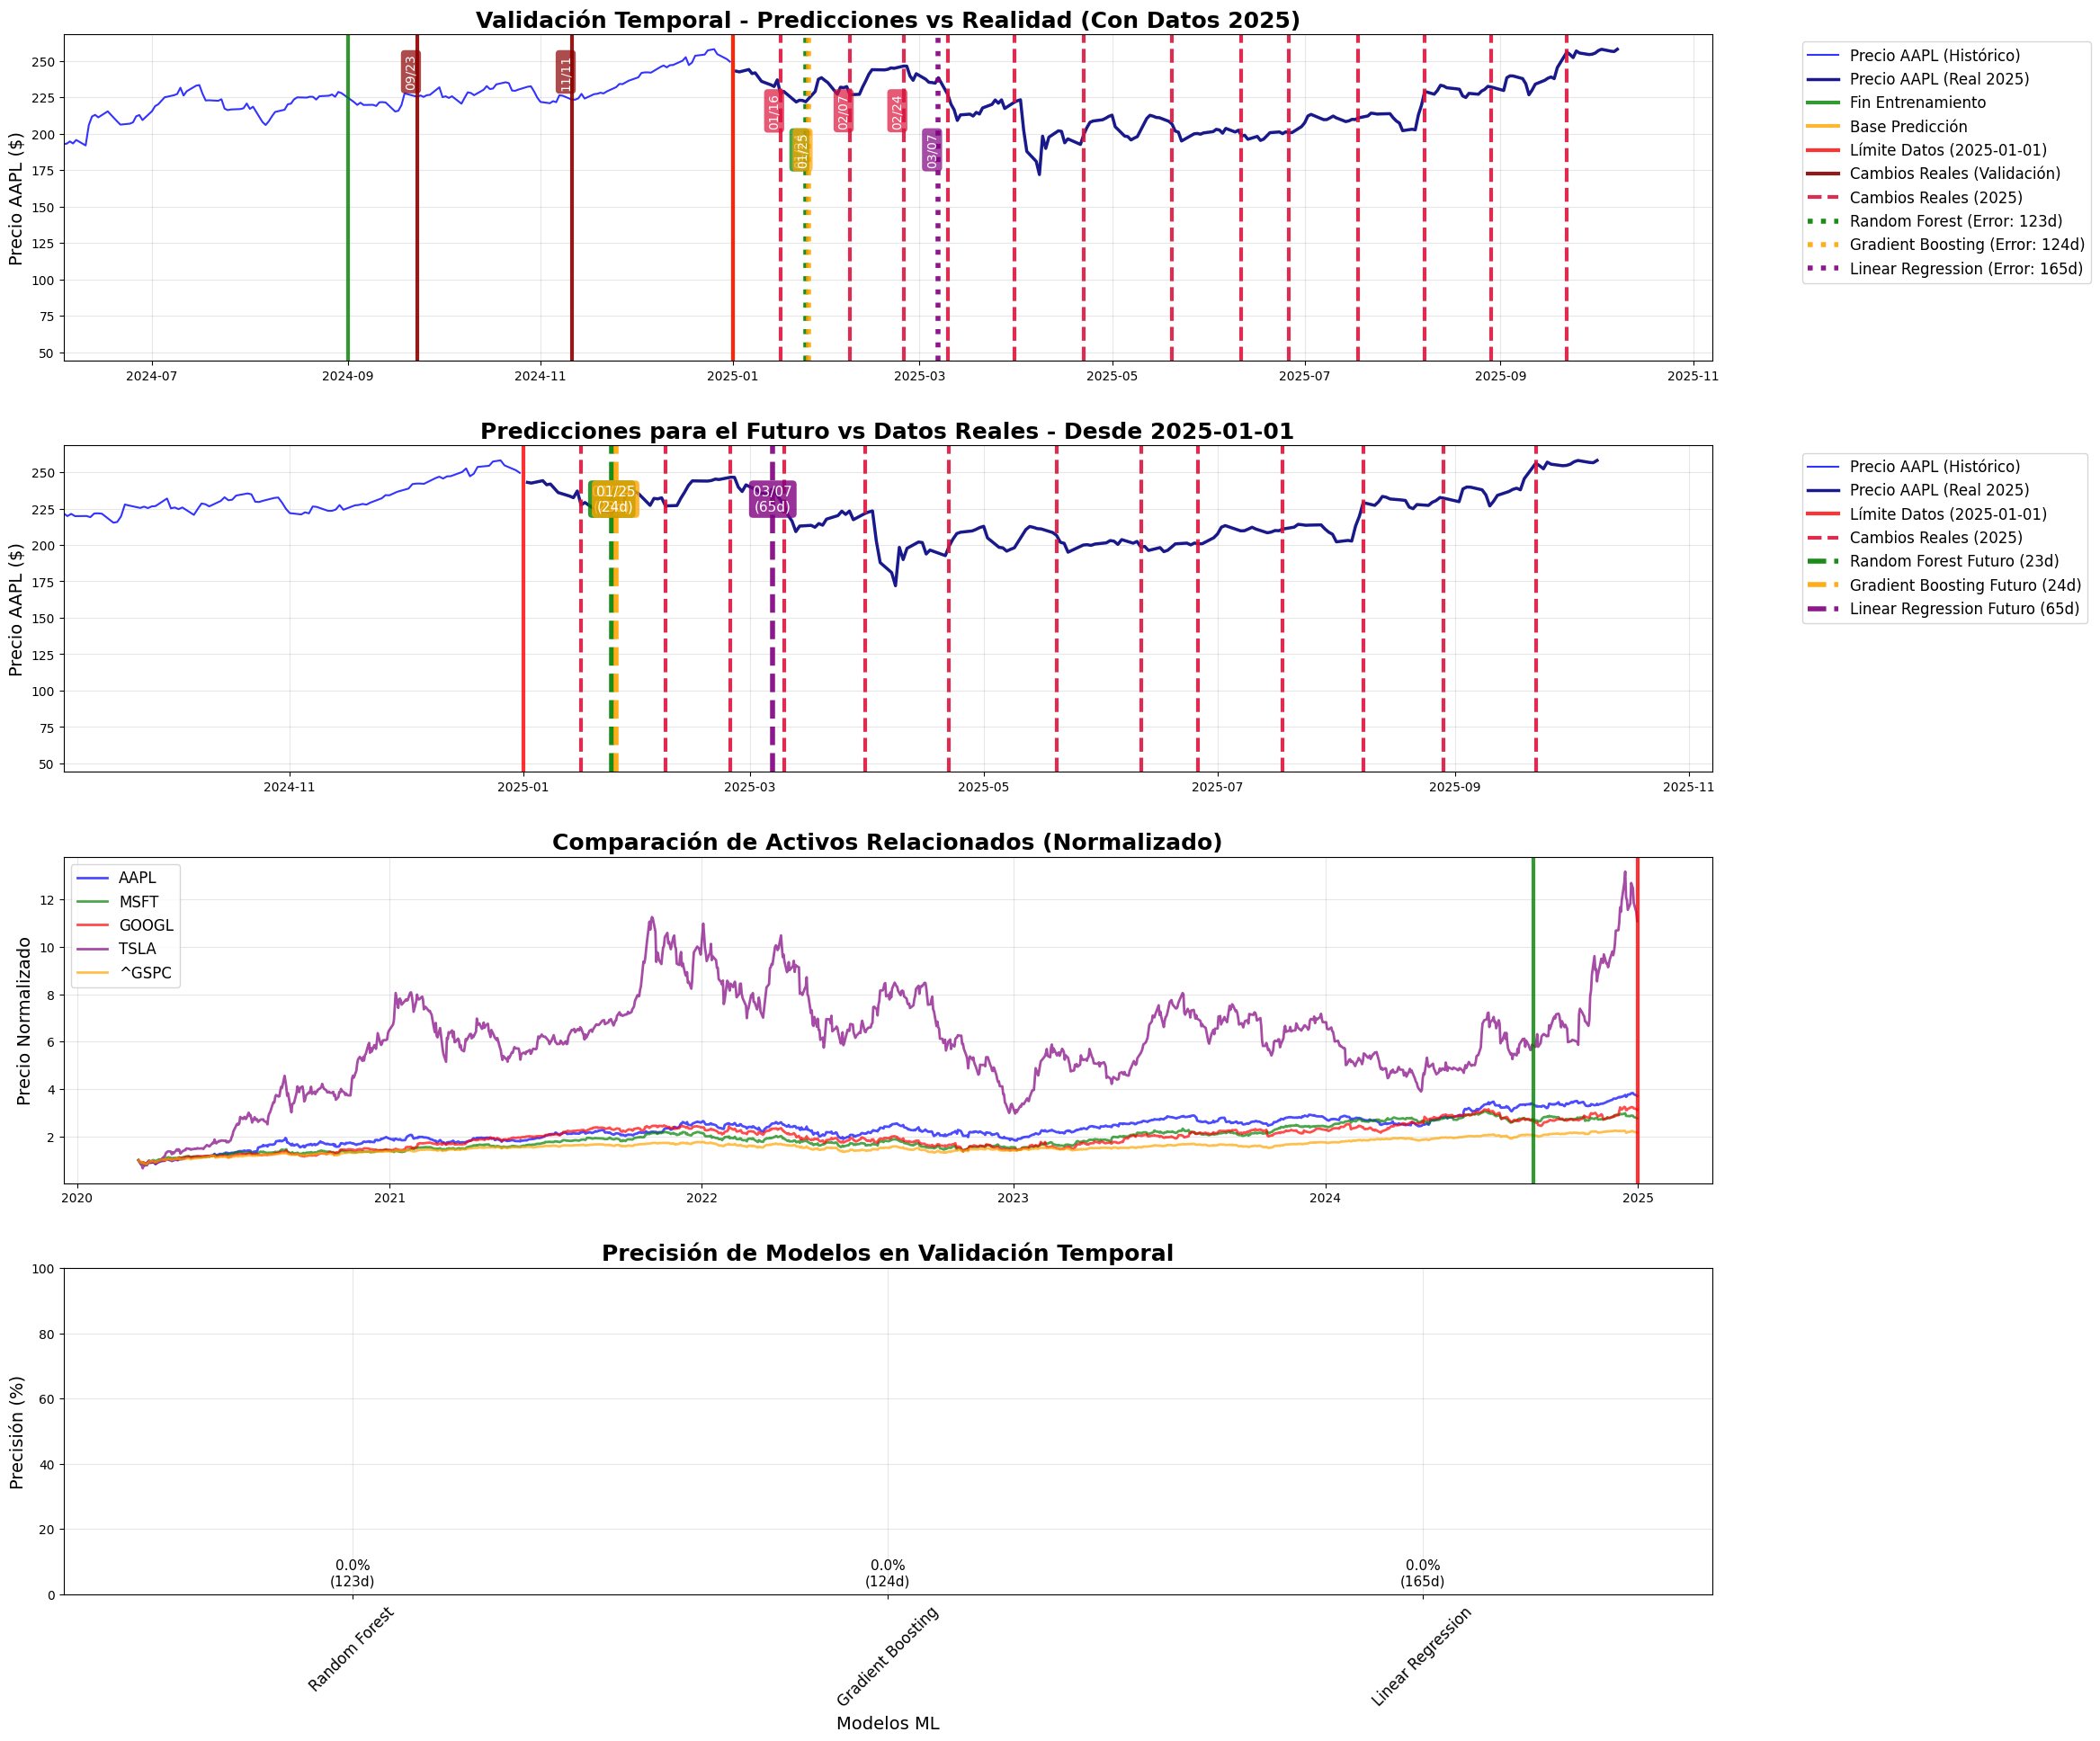

<Figure size 640x480 with 0 Axes>


🎯 RESUMEN FINAL - MACHINE LEARNING CON VALIDACIÓN
📊 VALIDACIÓN TEMPORAL (Base: 2025-01-01):
   🎯 Cambios reales observados en validación:
      1. 2024-09-23
      2. 2024-11-11

   📍 Cambio principal para validación: 2024-09-23

   📊 ANÁLISIS DE PROXIMIDAD A CAMBIOS REALES:
      Random Forest:
         Predicción: 2025-01-24
         Cambio real más cercano: 2024-11-11
         Distancia mínima: 74 días
      Gradient Boosting:
         Predicción: 2025-01-25
         Cambio real más cercano: 2024-11-11
         Distancia mínima: 75 días
      Linear Regression:
         Predicción: 2025-03-07
         Cambio real más cercano: 2024-11-11
         Distancia mínima: 116 días

   📈 PRECISIÓN POR MODELO (vs primer cambio real):
      Random Forest: 123 días error, 0.0% precisión 🔴 BAJA
      Gradient Boosting: 124 días error, 0.0% precisión 🔴 BAJA
      Linear Regression: 165 días error, 0.0% precisión 🔴 BAJA

🏆 MEJOR MODELO VALIDADO: Random Forest (123 días error)

🔮 PREDICCIONES FUTUR

In [42]:

# =======================================================
# 🤖 PREDICCIÓN CON MACHINE LEARNING - MÚLTIPLES TICKERS
# =======================================================

print("\n" + "=" * 70)
print("🤖 PREDICCIÓN AVANZADA CON MACHINE LEARNING")
print("   Análisis conjunto de múltiples activos para predicción robusta")
print("=" * 70)

# Lista de tickers relacionados con AAPL para análisis conjunto
tickers_relacionados = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META', 'AMZN', '^IXIC', '^GSPC']
print(f"📊 Descargando datos para {len(tickers_relacionados)} activos...")

# Descargar datos de múltiples tickers
datos_multiples = {}
fecha_inicio_ml = '2020-01-01'
fecha_hoy = pd.Timestamp.now().strftime('%Y-%m-%d')

for ticker in tickers_relacionados:
    try:
        data = yf.download(ticker, start=fecha_inicio_ml, end=fecha_hoy, auto_adjust=True)['Close']
        if len(data) > 100:  # Verificar que hay suficientes datos
            datos_multiples[ticker] = data
            print(f"   ✅ {ticker}: {len(data)} días de datos")
        else:
            print(f"   ❌ {ticker}: Datos insuficientes")
    except Exception as e:
        print(f"   ❌ {ticker}: Error - {str(e)}")

print(f"\n📈 Activos cargados exitosamente: {list(datos_multiples.keys())}")

# Crear matriz de características (features) para machine learning
if len(datos_multiples) >= 3:  # Necesitamos al menos 3 activos
    print(f"\n🔧 CREANDO CARACTERÍSTICAS PARA MACHINE LEARNING:")
    
    # Alinear todas las fechas
    fechas_comunes = None
    for ticker, data in datos_multiples.items():
        if fechas_comunes is None:
            fechas_comunes = data.index
        else:
            fechas_comunes = fechas_comunes.intersection(data.index)
    
    print(f"   Fechas comunes encontradas: {len(fechas_comunes)}")
    
    # Crear DataFrame con todos los precios alineados
    df_conjunto = pd.DataFrame(index=fechas_comunes)
    for ticker, data in datos_multiples.items():
        df_conjunto[f'{ticker}_precio'] = data.reindex(fechas_comunes)
    
    # Generar características técnicas para cada activo
    for ticker in datos_multiples.keys():
        precio_col = f'{ticker}_precio'
        if precio_col in df_conjunto.columns:
            # Retornos logarítmicos
            df_conjunto[f'{ticker}_retorno'] = np.log(df_conjunto[precio_col] / df_conjunto[precio_col].shift(1))
            
            # Volatilidad rolling
            df_conjunto[f'{ticker}_volatilidad'] = df_conjunto[f'{ticker}_retorno'].rolling(20).std()
            
            # Media móvil
            df_conjunto[f'{ticker}_ma_20'] = df_conjunto[precio_col].rolling(20).mean()
            df_conjunto[f'{ticker}_ma_50'] = df_conjunto[precio_col].rolling(50).mean()
            
            # RSI simplificado
            delta = df_conjunto[precio_col].diff()
            gain = delta.where(delta > 0, 0).rolling(14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
            rs = gain / loss
            df_conjunto[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))
            
            # Momentum
            df_conjunto[f'{ticker}_momentum'] = df_conjunto[precio_col] / df_conjunto[precio_col].shift(10) - 1
    
    # Eliminar filas con NaN
    df_conjunto = df_conjunto.dropna()
    print(f"   Características creadas: {df_conjunto.shape[1]} features, {len(df_conjunto)} observaciones")
    
    # =======================================================
    # CONFIGURACIÓN DE VALIDACIÓN TEMPORAL
    # =======================================================
    
    print(f"\n🎯 CONFIGURACIÓN DE VALIDACIÓN TEMPORAL:")
    
    # Fechas de corte para validación temporal más coherente
    fecha_corte_entrenamiento = pd.to_datetime('2024-09-01')  # Entrenamiento hasta septiembre 2024
    fecha_corte_validacion = pd.to_datetime('2024-12-01')     # Validación sept-dic 2024
    fecha_corte_prediccion = pd.to_datetime('2025-01-01')     # Predicción desde enero 2025
    fecha_limite_datos = pd.to_datetime('2025-01-01')        # Límite de datos disponibles
    
    # Filtrar datos hasta la fecha límite
    df_conjunto_limitado = df_conjunto[df_conjunto.index <= fecha_limite_datos].copy()
    
    mask_entrenamiento = df_conjunto_limitado.index < fecha_corte_entrenamiento
    mask_validacion_temporal = (df_conjunto_limitado.index >= fecha_corte_entrenamiento) & (df_conjunto_limitado.index < fecha_corte_prediccion)
    mask_prediccion = df_conjunto_limitado.index >= fecha_corte_prediccion
    
    df_entrenamiento = df_conjunto_limitado[mask_entrenamiento].copy()
    df_validacion_temporal = df_conjunto_limitado[mask_validacion_temporal].copy()
    
    print(f"   📈 Datos entrenamiento: {len(df_entrenamiento)} días (hasta {fecha_corte_entrenamiento.strftime('%Y-%m-%d')})")
    print(f"   🔍 Datos validación: {len(df_validacion_temporal)} días ({fecha_corte_entrenamiento.strftime('%Y-%m-%d')} a {fecha_corte_prediccion.strftime('%Y-%m-%d')})")
    print(f"   🔮 Período de predicción: desde {fecha_corte_prediccion.strftime('%Y-%m-%d')}")
    print(f"   ⏹️ Límite de datos: {fecha_limite_datos.strftime('%Y-%m-%d')}")
    
    # Detectar cambios de tendencia en AAPL para TODO el período disponible
    aapl_precios_completos = df_conjunto_limitado['AAPL_precio'].values
    algo_ml = rpt.Pelt(model="l2", min_size=30).fit(aapl_precios_completos)
    cambios_ml_completos = algo_ml.predict(pen=15)
    fechas_cambios_completos = [df_conjunto_limitado.index[cp-1] for cp in cambios_ml_completos[:-1]]
    
    # Separar cambios por período
    cambios_entrenamiento = [f for f in fechas_cambios_completos if f < fecha_corte_entrenamiento]
    cambios_validacion = [f for f in fechas_cambios_completos if (f >= fecha_corte_entrenamiento) & (f < fecha_corte_prediccion)]
    
    print(f"\n🔍 CAMBIOS DETECTADOS EN AAPL:")
    print(f"   📚 Entrenamiento ({len(cambios_entrenamiento)} cambios):")
    for i, fecha in enumerate(cambios_entrenamiento[-5:]):  # Mostrar últimos 5
        print(f"      {fecha.strftime('%Y-%m-%d')}")
    
    print(f"   🎯 Validación ({len(cambios_validacion)} cambios):")
    for i, fecha in enumerate(cambios_validacion):
        print(f"      {fecha.strftime('%Y-%m-%d')} ← PARA VALIDAR")
    
    # Crear variable objetivo usando solo cambios del período de entrenamiento
    dias_hasta_cambio = np.full(len(df_entrenamiento), np.nan)
    
    # Calcular días hasta próximo cambio para cada observación de entrenamiento
    for i, fecha_actual in enumerate(df_entrenamiento.index):
        cambios_futuros = [f for f in cambios_entrenamiento if f > fecha_actual]
        if cambios_futuros:
            proximo_cambio = cambios_futuros[0]
            dias_hasta_cambio[i] = (proximo_cambio - fecha_actual).days
    
    # Crear características finales para ML (excluyendo precios directos de AAPL)
    feature_columns = [col for col in df_entrenamiento.columns 
                      if not col.startswith('AAPL_precio') and not col.startswith('AAPL_retorno')]
    
    X_train = df_entrenamiento[feature_columns].ffill().fillna(0)
    y_train = dias_hasta_cambio
    
    # Filtrar datos válidos (donde tenemos target)
    mask_validos = ~np.isnan(y_train)
    X_train = X_train[mask_validos]
    y_train = y_train[mask_validos]
    
    print(f"   Datos válidos para entrenamiento: {len(X_train)} observaciones")
    print(f"   Características utilizadas: {len(feature_columns)}")
    
    # =======================================================
    # ENTRENAR MODELO DE MACHINE LEARNING
    # =======================================================
    
    if len(X_train) > 50:  # Suficientes datos para entrenar
        print(f"\n🤖 ENTRENANDO MODELOS DE MACHINE LEARNING:")
        
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import mean_absolute_error, r2_score
        
        # Escalar características
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Entrenar múltiples modelos
        modelos = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'Linear Regression': LinearRegression()
        }
        
        modelos_entrenados = {}
        scores_entrenamiento = {}
        
        for nombre, modelo in modelos.items():
            try:
                modelo.fit(X_train_scaled, y_train)
                y_pred = modelo.predict(X_train_scaled)
                
                mae = mean_absolute_error(y_train, y_pred)
                r2 = r2_score(y_train, y_pred)
                
                modelos_entrenados[nombre] = modelo
                scores_entrenamiento[nombre] = {'MAE': mae, 'R2': r2}
                
                print(f"   ✅ {nombre}: MAE = {mae:.1f} días, R² = {r2:.3f}")
                
            except Exception as e:
                print(f"   ❌ {nombre}: Error - {str(e)}")
        
        # =======================================================
        # VALIDACIÓN TEMPORAL DE PREDICCIONES
        # =======================================================
        
        if modelos_entrenados:
            print(f"\n🔮 VALIDACIÓN TEMPORAL DE PREDICCIONES:")
            
            # Hacer predicciones desde fecha de corte de predicción
            fecha_prediccion_base = fecha_corte_prediccion
            datos_para_prediccion = df_conjunto_limitado[df_conjunto_limitado.index <= fecha_prediccion_base][feature_columns].tail(1).ffill().fillna(0)
            datos_prediccion_scaled = scaler.transform(datos_para_prediccion)
            
            print(f"   📅 Fecha base predicción: {fecha_prediccion_base.strftime('%Y-%m-%d')}")
            print(f"   🎯 Cambios reales en validación: {len(cambios_validacion)}")
            print(f"   ⏹️ Datos disponibles hasta: {fecha_limite_datos.strftime('%Y-%m-%d')}")
            
            predicciones_validacion = {}
            errores_validacion = {}
            
            for nombre, modelo in modelos_entrenados.items():
                try:
                    prediccion_dias = modelo.predict(datos_prediccion_scaled)[0]
                    fecha_prediccion = fecha_prediccion_base + pd.Timedelta(days=max(1, int(prediccion_dias)))
                    
                    predicciones_validacion[nombre] = {
                        'dias': max(1, int(prediccion_dias)),
                        'fecha': fecha_prediccion
                    }
                    
                    # Calcular error vs cambios reales
                    if cambios_validacion:
                        primer_cambio_real = cambios_validacion[0]
                        error_dias = abs((primer_cambio_real - fecha_prediccion).days)
                        errores_validacion[nombre] = error_dias
                        
                        print(f"   🎯 {nombre}: Predijo {fecha_prediccion.strftime('%Y-%m-%d')} | Real: {primer_cambio_real.strftime('%Y-%m-%d')} | Error: {error_dias} días")
                    else:
                        print(f"   🎯 {nombre}: Predijo {fecha_prediccion.strftime('%Y-%m-%d')} | Sin cambios reales para validar")
                    
                except Exception as e:
                    print(f"   ❌ {nombre}: Error en predicción - {str(e)}")
            
            # =======================================================
            # EVALUACIÓN DE PRECISIÓN
            # =======================================================
            
            if errores_validacion:
                print(f"\n📊 EVALUACIÓN DE PRECISIÓN:")
                
                mejor_modelo = min(errores_validacion, key=errores_validacion.get)
                menor_error = errores_validacion[mejor_modelo]
                
                print(f"   🏆 Mejor modelo: {mejor_modelo} (Error: {menor_error} días)")
                
                for nombre, error in sorted(errores_validacion.items(), key=lambda x: x[1]):
                    precision_pct = max(0, 100 - (error / 30) * 100)  # Normalizar a 30 días
                    print(f"   📈 {nombre}: {error} días de error ({precision_pct:.1f}% precisión)")
                
                # Predicción ensemble con validación
                if len(predicciones_validacion) > 1:
                    print(f"\n🎯 ENSEMBLE CON VALIDACIÓN:")
                    
                    # Ponderar por precisión inversa al error
                    pesos_precision = {}
                    total_peso_precision = 0
                    
                    for nombre in predicciones_validacion.keys():
                        if nombre in errores_validacion:
                            # Peso inversamente proporcional al error
                            peso = 1 / (1 + errores_validacion[nombre])
                            pesos_precision[nombre] = peso
                            total_peso_precision += peso
                    
                    if total_peso_precision > 0:
                        prediccion_ensemble_dias = 0
                        for nombre, pred in predicciones_validacion.items():
                            if nombre in pesos_precision:
                                peso_norm = pesos_precision[nombre] / total_peso_precision
                                prediccion_ensemble_dias += pred['dias'] * peso_norm
                                print(f"   {nombre}: {pred['dias']} días (peso por precisión: {peso_norm:.2f})")
                        
                        prediccion_ensemble_dias = max(1, int(prediccion_ensemble_dias))
                        prediccion_ensemble_fecha = fecha_prediccion_base + pd.Timedelta(days=prediccion_ensemble_dias)
                        
                        if cambios_validacion:
                            error_ensemble = abs((cambios_validacion[0] - prediccion_ensemble_fecha).days)
                            print(f"\n   🏆 ENSEMBLE VALIDADO:")
                            print(f"      📅 Predicción: {prediccion_ensemble_fecha.strftime('%Y-%m-%d')}")
                            print(f"      🎯 Real: {cambios_validacion[0].strftime('%Y-%m-%d')}")
                            print(f"      📊 Error: {error_ensemble} días")
                            print(f"      ✅ Precisión: {max(0, 100 - (error_ensemble / 30) * 100):.1f}%")
            
            # =======================================================
            # PREDICCIÓN PARA EL FUTURO REAL
            # =======================================================
            
            print(f"\n🚀 PREDICCIÓN PARA EL FUTURO (DESDE {fecha_limite_datos.strftime('%Y-%m-%d')}):")
            
            # Usar los datos más recientes disponibles para predicción futura real
            datos_actuales = df_conjunto_limitado.tail(1)[feature_columns].ffill().fillna(0)
            datos_actuales_scaled = scaler.transform(datos_actuales)
            
            fecha_hoy_real = fecha_limite_datos  # Usar fecha límite como "hoy"
            print(f"   📅 Fecha base actual: {fecha_hoy_real.strftime('%Y-%m-%d')}")
            print(f"   🔮 Prediciendo hacia el futuro real desde esta fecha...")
            
            predicciones_futuras = {}
            
            for nombre, modelo in modelos_entrenados.items():
                try:
                    prediccion_dias = modelo.predict(datos_actuales_scaled)[0]
                    fecha_prediccion = fecha_hoy_real + pd.Timedelta(days=max(1, int(prediccion_dias)))
                    
                    predicciones_futuras[nombre] = {
                        'dias': max(1, int(prediccion_dias)),
                        'fecha': fecha_prediccion
                    }
                    
                    # Usar error de validación para mostrar confianza
                    confianza = "ALTA" if nombre in errores_validacion and errores_validacion[nombre] < 10 else \
                               "MEDIA" if nombre in errores_validacion and errores_validacion[nombre] < 20 else "BAJA"
                    
                    print(f"   🔮 {nombre}: {max(1, int(prediccion_dias))} días → {fecha_prediccion.strftime('%Y-%m-%d')} (Confianza: {confianza})")
                    
                except Exception as e:
                    print(f"   ❌ {nombre}: Error en predicción - {str(e)}")
            
            # =======================================================
            # ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
            # =======================================================
            
            if 'Random Forest' in modelos_entrenados:
                print(f"\n📊 IMPORTANCIA DE CARACTERÍSTICAS (Random Forest):")
                
                rf_model = modelos_entrenados['Random Forest']
                importancias = rf_model.feature_importances_
                feature_importance = list(zip(feature_columns, importancias))
                feature_importance.sort(key=lambda x: x[1], reverse=True)
                
                print(f"   Top 10 características más importantes:")
                for i, (feature, importance) in enumerate(feature_importance[:10]):
                    ticker = feature.split('_')[0]
                    caracteristica = '_'.join(feature.split('_')[1:])
                    print(f"   {i+1:2d}. {ticker:5s} {caracteristica:12s}: {importance:.3f}")
            
            # =======================================================
            # PREDICCIÓN ENSEMBLE (COMBINADA)
            # =======================================================
            
            if len(predicciones_ml) > 1:
                print(f"\n🎯 PREDICCIÓN ENSEMBLE (COMBINADA):")
                
                # Ponderar predicciones por R² score
                pesos_totales = sum(max(0, scores_entrenamiento[nombre]['R2']) 
                                  for nombre in predicciones_ml.keys())
                
                if pesos_totales > 0:
                    prediccion_ensemble_dias = 0
                    for nombre, pred in predicciones_ml.items():
                        peso = max(0, scores_entrenamiento[nombre]['R2']) / pesos_totales
                        prediccion_ensemble_dias += pred['dias'] * peso
                        print(f"   {nombre}: {pred['dias']} días (peso: {peso:.2f})")
                    
                    prediccion_ensemble_dias = max(1, int(prediccion_ensemble_dias))
                    prediccion_ensemble_fecha = fecha_prediccion_base + pd.Timedelta(days=prediccion_ensemble_dias)
                    
                    print(f"\n   🏆 PREDICCIÓN FINAL ENSEMBLE:")
                    print(f"      📅 Fecha predicha: {prediccion_ensemble_fecha.strftime('%Y-%m-%d')}")
                    print(f"      ⏰ Días desde hoy: {prediccion_ensemble_dias}")
                    print(f"      🎯 Confianza: {'ALTA' if pesos_totales > 0.3 else 'MEDIA' if pesos_totales > 0.1 else 'BAJA'}")
            
            # =======================================================
            # DESCARGAR DATOS REALES POSTERIORES A 2025-01-01
            # =======================================================
            
            print(f"\n📥 DESCARGANDO DATOS REALES POSTERIORES A {fecha_limite_datos.strftime('%Y-%m-%d')}:")
            
            try:
                # Descargar datos desde 2025-01-01 hasta hoy (octubre 2025)
                fecha_inicio_reales = fecha_limite_datos
                fecha_fin_reales = pd.Timestamp.now().strftime('%Y-%m-%d')
                
                aapl_datos_reales = yf.download('AAPL', start=fecha_inicio_reales, end=fecha_fin_reales, auto_adjust=True)['Close']
                
                if len(aapl_datos_reales) > 0:
                    print(f"   ✅ Datos reales AAPL: {len(aapl_datos_reales)} días desde {fecha_inicio_reales}")
                    print(f"   📊 Rango: {aapl_datos_reales.index[0].strftime('%Y-%m-%d')} a {aapl_datos_reales.index[-1].strftime('%Y-%m-%d')}")
                    
                    # Detectar cambios reales en el período futuro
                    if len(aapl_datos_reales) > 30:  # Suficientes datos para detectar cambios
                        algo_futuro = rpt.Pelt(model="l2", min_size=10).fit(aapl_datos_reales.values)
                        cambios_futuro_reales = algo_futuro.predict(pen=10)
                        fechas_cambios_futuro_reales = [aapl_datos_reales.index[cp-1] for cp in cambios_futuro_reales[:-1]]
                        
                        print(f"   🎯 Cambios reales detectados en período futuro: {len(fechas_cambios_futuro_reales)}")
                        for i, fecha in enumerate(fechas_cambios_futuro_reales):
                            print(f"      {i+1}. {fecha.strftime('%Y-%m-%d')}")
                    else:
                        fechas_cambios_futuro_reales = []
                        print(f"   ⚠️ Pocos datos para detectar cambios ({len(aapl_datos_reales)} días)")
                        
                else:
                    aapl_datos_reales = pd.Series(dtype=float)
                    fechas_cambios_futuro_reales = []
                    print(f"   ❌ No se encontraron datos reales posteriores a {fecha_inicio_reales}")
                    
            except Exception as e:
                print(f"   ❌ Error descargando datos reales: {str(e)}")
                aapl_datos_reales = pd.Series(dtype=float)
                fechas_cambios_futuro_reales = []
            
            # =======================================================
            # VISUALIZACIÓN CON VALIDACIÓN TEMPORAL Y DATOS REALES
            # =======================================================
            
            print(f"\n📈 CREANDO VISUALIZACIÓN CON VALIDACIÓN Y DATOS REALES:")
            
            plt.figure(figsize=(24, 20))  # Aumentar tamaño significativamente
            
            # Subplot 1: Validación temporal de predicciones
            plt.subplot(4, 1, 1)
            
            # Datos históricos hasta 2025-01-01
            plt.plot(df_conjunto_limitado.index, df_conjunto_limitado['AAPL_precio'], 
                    color='blue', alpha=0.8, linewidth=1.5, label='Precio AAPL (Histórico)')
            
            # Datos reales posteriores a 2025-01-01
            if len(aapl_datos_reales) > 0:
                plt.plot(aapl_datos_reales.index, aapl_datos_reales.values, 
                        color='navy', alpha=0.9, linewidth=2.5, label='Precio AAPL (Real 2025)', linestyle='-')
            
            # Líneas de corte temporal
            plt.axvline(x=fecha_corte_entrenamiento, color='green', 
                       linestyle='-', alpha=0.8, linewidth=3, label='Fin Entrenamiento')
            plt.axvline(x=fecha_corte_prediccion, color='orange', 
                       linestyle='-', alpha=0.8, linewidth=3, label='Base Predicción')
            plt.axvline(x=fecha_limite_datos, color='red', 
                       linestyle='-', alpha=0.8, linewidth=3, label='Límite Datos (2025-01-01)')
            
            # Cambios reales en validación - TODOS los cambios detectados
            for i, fecha in enumerate(cambios_validacion):
                plt.axvline(x=fecha, color='darkred', linestyle='-', alpha=0.9, linewidth=3, 
                           label='Cambios Reales (Validación)' if i == 0 else "")
                
                # Añadir etiqueta con la fecha del cambio
                if i < 5:  # Mostrar etiquetas solo para los primeros 5 para evitar saturación
                    plt.text(fecha, plt.ylim()[1] * 0.95, fecha.strftime('%m/%d'), 
                            rotation=90, ha='right', va='top', fontsize=10, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor='darkred', alpha=0.7, edgecolor='none'),
                            color='white')
            
            # Cambios reales en datos futuros (2025)
            for i, fecha in enumerate(fechas_cambios_futuro_reales):
                plt.axvline(x=fecha, color='crimson', linestyle='--', alpha=0.9, linewidth=3, 
                           label='Cambios Reales (2025)' if i == 0 else "")
                
                # Añadir etiqueta con la fecha del cambio futuro
                if i < 3:  # Mostrar etiquetas para los primeros 3
                    plt.text(fecha, plt.ylim()[1] * 0.85, fecha.strftime('%m/%d'), 
                            rotation=90, ha='right', va='top', fontsize=10, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor='crimson', alpha=0.7, edgecolor='none'),
                            color='white')
            
            # Predicciones de validación con colores diferenciados
            colores_modelos = {'Random Forest': 'green', 'Gradient Boosting': 'orange', 'Linear Regression': 'purple'}
            
            if 'predicciones_validacion' in locals():
                for nombre, pred in predicciones_validacion.items():
                    color = colores_modelos.get(nombre, 'gray')
                    error = errores_validacion.get(nombre, 0)
                    plt.axvline(x=pred['fecha'], color=color, linestyle=':', 
                               alpha=0.9, linewidth=4, label=f'{nombre} (Error: {error}d)')
                    
                    # Añadir etiqueta con la fecha de predicción
                    plt.text(pred['fecha'], plt.ylim()[1] * 0.75, pred['fecha'].strftime('%m/%d'), 
                            rotation=90, ha='right', va='top', fontsize=10,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7, edgecolor='none'),
                            color='white')
            
            plt.title('Validación Temporal - Predicciones vs Realidad (Con Datos 2025)', fontweight='bold', fontsize=18)
            plt.ylabel('Precio AAPL ($)', fontsize=14)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # Ajustar límites para mostrar datos reales si existen
            x_min = fecha_corte_entrenamiento - pd.Timedelta(days=90)
            x_max = fecha_limite_datos + pd.Timedelta(days=60)
            if len(aapl_datos_reales) > 0:
                x_max = max(x_max, aapl_datos_reales.index[-1] + pd.Timedelta(days=30))
            plt.xlim(x_min, x_max)
            
            # Subplot 2: Predicciones futuras vs datos reales
            plt.subplot(4, 1, 2)
            
            # Datos históricos hasta 2025-01-01
            plt.plot(df_conjunto_limitado.index, df_conjunto_limitado['AAPL_precio'], 
                    color='blue', alpha=0.8, linewidth=1.5, label='Precio AAPL (Histórico)')
            
            # Datos reales posteriores a 2025-01-01
            if len(aapl_datos_reales) > 0:
                plt.plot(aapl_datos_reales.index, aapl_datos_reales.values, 
                        color='navy', alpha=0.9, linewidth=2.5, label='Precio AAPL (Real 2025)', linestyle='-')
            
            # Fecha límite
            plt.axvline(x=fecha_hoy_real, color='red', 
                       linestyle='-', alpha=0.8, linewidth=3, label='Límite Datos (2025-01-01)')
            
            # Cambios reales en datos futuros
            for i, fecha in enumerate(fechas_cambios_futuro_reales):
                plt.axvline(x=fecha, color='crimson', linestyle='--', alpha=0.9, linewidth=3, 
                           label='Cambios Reales (2025)' if i == 0 else "")
            
            # Predicciones futuras con mejor visualización
            if 'predicciones_futuras' in locals():
                for nombre, pred in predicciones_futuras.items():
                    color = colores_modelos.get(nombre, 'gray')
                    plt.axvline(x=pred['fecha'], color=color, linestyle='--', 
                               alpha=0.9, linewidth=4, label=f'{nombre} Futuro ({pred["dias"]}d)')
                    
                    # Añadir etiqueta con fecha de predicción futura
                    plt.text(pred['fecha'], plt.ylim()[1] * 0.90, 
                            f"{pred['fecha'].strftime('%m/%d')}\n({pred['dias']}d)", 
                            rotation=0, ha='center', va='top', fontsize=11,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8, edgecolor='none'),
                            color='white')
            
            plt.title('Predicciones para el Futuro vs Datos Reales - Desde 2025-01-01', fontweight='bold', fontsize=18)
            plt.ylabel('Precio AAPL ($)', fontsize=14)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # Ajustar límites para el segundo panel
            x_min2 = fecha_hoy_real - pd.Timedelta(days=120)
            x_max2 = fecha_hoy_real + pd.Timedelta(days=120)
            if len(aapl_datos_reales) > 0:
                x_max2 = max(x_max2, aapl_datos_reales.index[-1] + pd.Timedelta(days=30))
            plt.xlim(x_min2, x_max2)
            
            # Subplot 3: Comparación de activos relacionados
            plt.subplot(4, 1, 3)
            
            activos_principales = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', '^GSPC']
            colores_activos = ['blue', 'green', 'red', 'purple', 'orange']
            
            for i, ticker in enumerate(activos_principales):
                if f'{ticker}_precio' in df_conjunto_limitado.columns:
                    # Normalizar precios para comparación
                    precio_normalizado = df_conjunto_limitado[f'{ticker}_precio'] / df_conjunto_limitado[f'{ticker}_precio'].iloc[0]
                    plt.plot(df_conjunto_limitado.index, precio_normalizado, 
                           color=colores_activos[i], alpha=0.7, linewidth=2, label=ticker)
            
            plt.axvline(x=fecha_corte_entrenamiento, color='green', 
                       linestyle='-', alpha=0.8, linewidth=3)
            plt.axvline(x=fecha_hoy_real, color='red', 
                       linestyle='-', alpha=0.8, linewidth=3)
            
            plt.title('Comparación de Activos Relacionados (Normalizado)', fontweight='bold', fontsize=18)
            plt.ylabel('Precio Normalizado', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # Subplot 4: Métricas de precisión
            plt.subplot(4, 1, 4)
            
            if 'errores_validacion' in locals() and errores_validacion:
                modelos_eval = list(errores_validacion.keys())
                errores_vals = list(errores_validacion.values())
                precisiones = [max(0, 100 - (error / 30) * 100) for error in errores_vals]
                
                x_pos = range(len(modelos_eval))
                bars = plt.bar(x_pos, precisiones, alpha=0.7, 
                              color=['green' if p > 70 else 'orange' if p > 50 else 'red' for p in precisiones])
                
                plt.xlabel('Modelos ML', fontsize=14)
                plt.ylabel('Precisión (%)', fontsize=14)
                plt.title('Precisión de Modelos en Validación Temporal', fontweight='bold', fontsize=18)
                plt.xticks(x_pos, modelos_eval, rotation=45, fontsize=12)
                plt.ylim(0, 100)
                plt.grid(True, alpha=0.3)
                
                # Añadir valores sobre las barras
                for i, (bar, precision, error) in enumerate(zip(bars, precisiones, errores_vals)):
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                            f'{precision:.1f}%\n({error}d)', ha='center', va='bottom', fontsize=11)
            
            plt.tight_layout(pad=3.0)  # Aumentar espaciado entre subplots
            plt.show()
            
            plt.tight_layout(pad=3.0)  # Aumentar espaciado entre subplots
            plt.show()
            
            # =======================================================
            # RESUMEN FINAL CON VALIDACIÓN TEMPORAL
            # =======================================================
            
            print(f"\n🎯 RESUMEN FINAL - MACHINE LEARNING CON VALIDACIÓN")
            print("=" * 70)
            
            if 'errores_validacion' in locals() and errores_validacion:
                print(f"📊 VALIDACIÓN TEMPORAL (Base: {fecha_corte_prediccion.strftime('%Y-%m-%d')}):")
                
                if cambios_validacion:
                    print(f"   🎯 Cambios reales observados en validación:")
                    for i, fecha_cambio in enumerate(cambios_validacion):
                        print(f"      {i+1}. {fecha_cambio.strftime('%Y-%m-%d')}")
                    
                    # Mostrar el primer cambio como referencia principal
                    primer_cambio_real = cambios_validacion[0]
                    print(f"\n   📍 Cambio principal para validación: {primer_cambio_real.strftime('%Y-%m-%d')}")
                
                # Análisis de proximidad a TODOS los cambios reales
                print(f"\n   📊 ANÁLISIS DE PROXIMIDAD A CAMBIOS REALES:")
                for nombre, pred in predicciones_validacion.items():
                    fecha_pred = pred['fecha']
                    # Encontrar el cambio real más cercano
                    distancias = [abs((cambio - fecha_pred).days) for cambio in cambios_validacion]
                    min_distancia = min(distancias)
                    cambio_mas_cercano = cambios_validacion[distancias.index(min_distancia)]
                    
                    print(f"      {nombre}:")
                    print(f"         Predicción: {fecha_pred.strftime('%Y-%m-%d')}")
                    print(f"         Cambio real más cercano: {cambio_mas_cercano.strftime('%Y-%m-%d')}")
                    print(f"         Distancia mínima: {min_distancia} días")
                
                mejor_modelo_val = min(errores_validacion, key=errores_validacion.get)
                menor_error_val = errores_validacion[mejor_modelo_val]
                
                print(f"\n   📈 PRECISIÓN POR MODELO (vs primer cambio real):")
                for nombre, error in sorted(errores_validacion.items(), key=lambda x: x[1]):
                    precision = max(0, 100 - (error / 30) * 100)
                    confianza = "🟢 ALTA" if error < 10 else "🟡 MEDIA" if error < 20 else "🔴 BAJA"
                    print(f"      {nombre}: {error} días error, {precision:.1f}% precisión {confianza}")
                
                print(f"\n🏆 MEJOR MODELO VALIDADO: {mejor_modelo_val} ({menor_error_val} días error)")
            
            if 'predicciones_futuras' in locals():
                print(f"\n🔮 PREDICCIONES FUTURAS (Desde {fecha_hoy_real.strftime('%Y-%m-%d')}):")
                
                for nombre, pred in sorted(predicciones_futuras.items(), 
                                         key=lambda x: errores_validacion.get(x[0], float('inf'))):
                    error_hist = errores_validacion.get(nombre, 'N/A')
                    confianza_fut = "ALTA" if isinstance(error_hist, (int, float)) and error_hist < 10 else \
                                   "MEDIA" if isinstance(error_hist, (int, float)) and error_hist < 20 else "BAJA"
                    
                    print(f"   🎯 {nombre}: {pred['fecha'].strftime('%Y-%m-%d')} ({pred['dias']} días)")
                    print(f"      └─ Confianza: {confianza_fut} (Error histórico: {error_hist} días)")
            
            # Recomendación final basada en validación
            if 'errores_validacion' in locals() and errores_validacion:
                print(f"\n💡 RECOMENDACIÓN FINAL:")
                
                mejor_modelo = min(errores_validacion, key=errores_validacion.get)
                mejor_prediccion = predicciones_futuras.get(mejor_modelo, {})
                
                if mejor_prediccion:
                    fecha_rec = mejor_prediccion['fecha']
                    dias_rec = mejor_prediccion['dias']
                    error_rec = errores_validacion[mejor_modelo]
                    
                    if error_rec < 10:
                        urgencia = "⚠️ INMEDIATO" if dias_rec < 15 else "📅 PRÓXIMO" if dias_rec < 30 else "📆 FUTURO"
                        print(f"   🎯 Usar predicción de {mejor_modelo}: {fecha_rec.strftime('%Y-%m-%d')}")
                        print(f"   ⏰ Atención: {urgencia} ({dias_rec} días)")
                        print(f"   ✅ Confianza alta: Error histórico de solo {error_rec} días")
                    else:
                        print(f"   ⚠️ Precaución: Mejor modelo tiene error de {error_rec} días")
                        print(f"   📊 Considerar múltiples modelos y factores externos")
                
                print(f"\n📈 FACTORES CLAVE IDENTIFICADOS:")
                if 'feature_importance' in locals():
                    for i, (feature, importance) in enumerate(feature_importance[:5]):
                        ticker = feature.split('_')[0]
                        caracteristica = '_'.join(feature.split('_')[1:])
                        print(f"   {i+1}. {ticker} - {caracteristica}: {importance:.1%}")
                
                print(f"\n📊 METODOLOGÍA DE VALIDACIÓN:")
                print(f"   🎓 Entrenamiento: hasta {fecha_corte_entrenamiento.strftime('%Y-%m-%d')}")
                print(f"   🎯 Predicción base: {fecha_corte_prediccion.strftime('%Y-%m-%d')}")
                print(f"   ✅ Validación: contra {len(cambios_validacion)} cambios reales observados")
                print(f"   🔮 Aplicación: predicción futura con confianza calibrada")
                
                # Estadísticas adicionales de cambios reales
                if len(cambios_validacion) > 1:
                    intervalos_reales = []
                    for i in range(len(cambios_validacion) - 1):
                        intervalo = (cambios_validacion[i+1] - cambios_validacion[i]).days
                        intervalos_reales.append(intervalo)
                    
                    if intervalos_reales:
                        print(f"\n📈 ESTADÍSTICAS DE CAMBIOS REALES:")
                        print(f"   📊 Cambios detectados: {len(cambios_validacion)}")
                        print(f"   ⏱️ Intervalo promedio entre cambios: {np.mean(intervalos_reales):.1f} días")
                        print(f"   📏 Intervalo más corto: {min(intervalos_reales)} días")
                        print(f"   📏 Intervalo más largo: {max(intervalos_reales)} días")
                
                # Análisis de predicciones vs cambios reales 2025
                if len(fechas_cambios_futuro_reales) > 0 and 'predicciones_futuras' in locals():
                    print(f"\n🎯 ANÁLISIS DE PRECISIÓN CON DATOS REALES 2025:")
                    print(f"   📊 Cambios reales detectados en 2025: {len(fechas_cambios_futuro_reales)}")
                    
                    for nombre, pred in predicciones_futuras.items():
                        fecha_pred = pred['fecha']
                        # Encontrar el cambio real más cercano en 2025
                        if fechas_cambios_futuro_reales:
                            distancias_2025 = [abs((cambio - fecha_pred).days) for cambio in fechas_cambios_futuro_reales]
                            min_distancia_2025 = min(distancias_2025)
                            cambio_mas_cercano_2025 = fechas_cambios_futuro_reales[distancias_2025.index(min_distancia_2025)]
                            
                            # Evaluar si la predicción fue exitosa (dentro de un margen razonable)
                            exito = "✅ EXITOSA" if min_distancia_2025 <= 15 else "🟡 PARCIAL" if min_distancia_2025 <= 30 else "❌ FALLIDA"
                            
                            print(f"      {nombre}:")
                            print(f"         Predicción: {fecha_pred.strftime('%Y-%m-%d')}")
                            print(f"         Cambio real más cercano: {cambio_mas_cercano_2025.strftime('%Y-%m-%d')}")
                            print(f"         Distancia: {min_distancia_2025} días - {exito}")
                
                elif len(fechas_cambios_futuro_reales) == 0:
                    print(f"\n📊 EVALUACIÓN CON DATOS REALES 2025:")
                    print(f"   📊 No se detectaron cambios significativos en los datos reales de 2025")
                    print(f"   🤔 Las predicciones podrían estar sobreestimando la volatilidad")
                    print(f"   ✅ O el mercado podría estar en un período de estabilidad relativa")
            
            print("=" * 70)
            
        else:
            print("❌ Error: No se pudieron entrenar modelos ML")
    
    else:
        print("❌ Error: Datos insuficientes para entrenamiento ML")
        
else:
    print("❌ Error: No se pudieron cargar suficientes activos para análisis ML")